In [1]:
%matplotlib inline

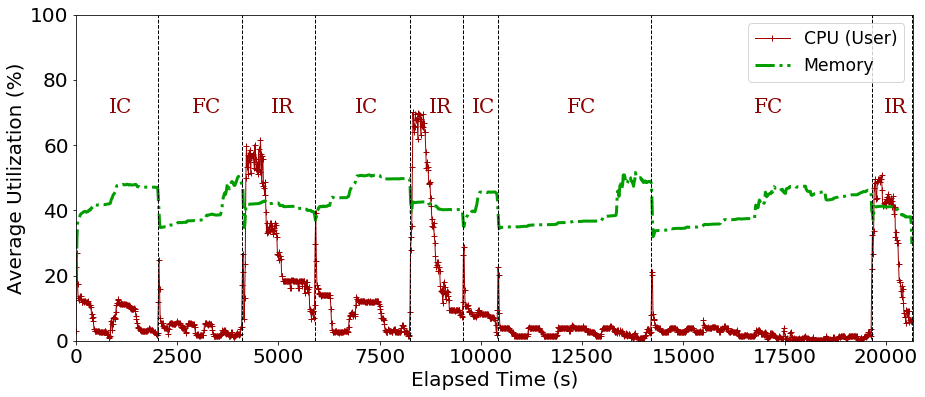

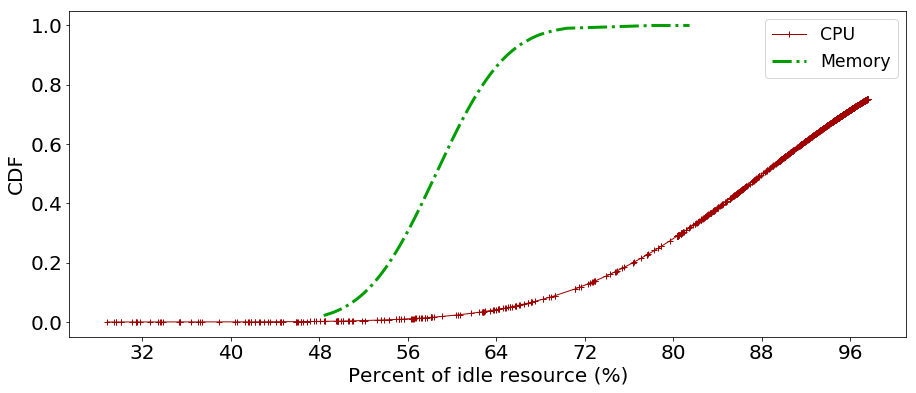

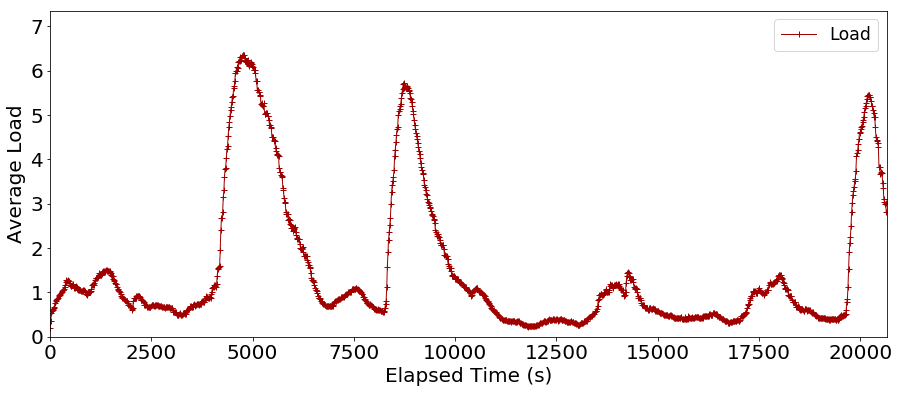

In [4]:
import os
import glob
import json
import rrdtool
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from datetime import datetime, timedelta
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties


def interpolate_NaN_1d(data):
    not_NaN = np.logical_not(np.isnan(data))
    indices = np.arange(len(data))
    interpolated_data = np.interp(indices, indices[not_NaN], data[not_NaN])
    return interpolated_data


base_dir = "/Users/habib/Desktop/standalone_static_128MB_1cpu_2gb_nospeculation/"

jobs_log_file = base_dir + "experiment_logs"
base_rdd_dir = base_dir + "rrds/sparkCluster/"

jobs_log_dir = base_dir+"jobs_log/"
processed_logs_dir = jobs_log_dir+"processed_logs/"

json_file_names = glob.glob(processed_logs_dir+"*.json")

exclude_dirs = ["__SummaryInfo__", "discus-p2irc-master"]

fetch_start_time = ""
fetch_end_time = ""
fetch_resolution = "15"

rrd_data = {}

with open(jobs_log_file) as logs:
    for line in logs:
        if("start" in line):
            fetch_start_time = line.split(" ")[3]
        elif("end" in line):
            fetch_end_time = line.split(" ")[3]
            
# Create output directory if it does not already exist
if not os.path.exists(processed_logs_dir):
    os.makedirs(processed_logs_dir)

# Get all file names in the working directory
all_files = glob.glob(jobs_log_dir+"*")

# Filter the files that have .txt, .py, .png, .jpg extension.
# This leaves us with only the log files which don't have any extension
log_files_name = [file for file in all_files if not "." in file and not os.path.isdir(file)]

for fileName in log_files_name:

    # A list to hold the parsed json
    parsedLogFile = []
    with open(fileName) as logFile:
        fileName = fileName.split("/")[-1]
        for jsonLine in logFile:
            try:
                # Parse each json line by line
                parsedLogFile.append(json.loads(jsonLine))
            except: 
                pass
        
        # Print the parsed json with indentation of 4
        jsonFormatted = json.dumps(parsedLogFile, indent=4, sort_keys=True)

        # Add .json format to the original log filename
        jsonFormatedLogFileName = fileName+".json"

        # Delete the json file if it already exist in the directory
        try:
            os.remove(jsonFormatedLogFileName)
        except OSError:
            pass

        # Save the a copy of the original logfile as a formatted json file
        f = open(processed_logs_dir+jsonFormatedLogFileName, 'w')
        print(jsonFormatted, file=f)
        f.close()

        
vlines = []        

for fileName in json_file_names:

    first_executor = False

    data = [line.strip() for line in open(fileName, 'r')]
    
    app_name = ""
    app_start_time = ""
    app_end_time = ""
    
    for index, line in enumerate(data):
        if "App Name" in line:
            app_name = line.strip().split("\"")[3] 
        if "SparkListenerApplicationEnd" in line:
            app_end_time = (data[index+1]).replace(",","").split(":")[1].strip() 
        if "SparkListenerExecutorAdded" in line and not first_executor:
            
            offset = 0
            while not ("Timestamp" in data[index+offset]):
                offset = offset + 1
                
            first_executor_time = (data[index+offset]).replace(",","").split(":")[1].strip()
            first_executor = True            
                            
    app_start_time = round((float(first_executor_time)/1000.0) - float(fetch_start_time))
    app_end_time = round((float(app_end_time)/1000.0) - float(fetch_start_time))
    
    if "imageClustering" in app_name:
        vlines.append(("IC", app_start_time, app_end_time))
    if "flowerCounter" in app_name:
        vlines.append(("FC", app_start_time, app_end_time))
    if "imageRegistration" in app_name:
        vlines.append(("IR", app_start_time, app_end_time))
        

for (dirpath, dirnames, filenames) in os.walk(base_rdd_dir):
    
    dirnames[:] = [d for d in dirnames if d not in exclude_dirs and not d[0] == '.']
    filenames = [f for f in filenames if not f[0] == '.']    
    
    for file in filenames:
        full_file_path = os.path.join(dirpath, file)
        splitted_file_path = full_file_path.split("/")
        metric_name = splitted_file_path[-2]+" "+splitted_file_path[-1]
        metric_name = metric_name[:-4]
                
        time_info,_,data = rrdtool.fetch(full_file_path, "AVERAGE", "--resolution", fetch_resolution, "--start", fetch_start_time, "--end", fetch_end_time)
        start_time = time_info[0]
        end_time = time_info[1]
        resolution = time_info[2]
        
        data_with_time_stamp = []
        current_time = start_time
        
        for data_point in data:
            current_time = current_time + resolution
            data_with_time_stamp.append((current_time, data_point[0]))
        
        rrd_data[metric_name] = data_with_time_stamp

cpu_idle = []
cpu_user = []
cpu_wio = []

mem_dict = {}

bytes_in = []
bytes_out = []

load_one = []
load_five = []
load_fifteen = []

first_entry = rrd_data[list(rrd_data.keys())[0]]
time_stamp = [datetime.fromtimestamp(int(i[0])).strftime('%Y-%m-%dT%H:%M:%S') for i in first_entry]

for k,v in rrd_data.items():
    
    data_points = np.array([i[1] for i in v], dtype=np.float64)
            
    # Getting CPU metrics
    if "cpu_idle" in k:
        cpu_idle.append(data_points)
    if "cpu_user" in k:
        cpu_user.append(data_points)
    if "cpu_wio" in k:
        cpu_wio.append(data_points)
    
    # Getting network metrics
    if "bytes_in" in k: 
        bytes_in.append(data_points/1024)
    if "bytes_out" in k:
        bytes_out.append(data_points/1024)
        
    # Getting load metrics
    if "load_one" in k:
        load_one.append(data_points)
    if "load_five" in k:
        load_five.append(data_points)
    if "load_fifteen" in k:
        load_fifteen.append(data_points)
        
    # Getting memory metrics
    if "mem_" in k:
        mem_dict[k] = data_points
        
# Calculating the percentage of memory utilization for mario
mario_total_mem = [value for key, value in mem_dict.items() if ("mario" in key and "mem_total" in key)]
mario_free_mem = [value for key, value in mem_dict.items() if ("mario" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
mario_free_mem = np.sum(np.array(mario_free_mem), axis=0)

mario_mem_stacked = np.vstack((mario_total_mem, mario_free_mem)).T
mario_percentage_mem_utilization = ((mario_mem_stacked[:,0] - mario_mem_stacked[:,1]) / mario_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for luigi
luigi_total_mem = [value for key, value in mem_dict.items() if ("luigi" in key and "mem_total" in key)]
luigi_free_mem = [value for key, value in mem_dict.items() if ("luigi" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
luigi_free_mem = np.sum(np.array(luigi_free_mem), axis=0)

luigi_mem_stacked = np.vstack((luigi_total_mem, luigi_free_mem)).T
luigi_percentage_mem_utilization = ((luigi_mem_stacked[:,0] - luigi_mem_stacked[:,1]) / luigi_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker1
worker1_total_mem = [value for key, value in mem_dict.items() if ("worker1" in key and "mem_total" in key)]
worker1_free_mem = [value for key, value in mem_dict.items() if ("worker1" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker1_free_mem = np.sum(np.array(worker1_free_mem), axis=0)

worker1_mem_stacked = np.vstack((worker1_total_mem, worker1_free_mem)).T
worker1_percentage_mem_utilization = ((worker1_mem_stacked[:,0] - worker1_mem_stacked[:,1]) / worker1_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker2
worker2_total_mem = [value for key, value in mem_dict.items() if ("worker2" in key and "mem_total" in key)]
worker2_free_mem = [value for key, value in mem_dict.items() if ("worker2" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker2_free_mem = np.sum(np.array(worker2_free_mem), axis=0)

worker2_mem_stacked = np.vstack((worker2_total_mem, worker2_free_mem)).T
worker2_percentage_mem_utilization = ((worker2_mem_stacked[:,0] - worker2_mem_stacked[:,1]) / worker2_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker3
worker3_total_mem = [value for key, value in mem_dict.items() if ("worker3" in key and "mem_total" in key)]
worker3_free_mem = [value for key, value in mem_dict.items() if ("worker3" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker3_free_mem = np.sum(np.array(worker3_free_mem), axis=0)

worker3_mem_stacked = np.vstack((worker3_total_mem, worker3_free_mem)).T
worker3_percentage_mem_utilization = ((worker3_mem_stacked[:,0] - worker3_mem_stacked[:,1]) / worker3_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker4
worker4_total_mem = [value for key, value in mem_dict.items() if ("worker4" in key and "mem_total" in key)]
worker4_free_mem = [value for key, value in mem_dict.items() if ("worker4" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker4_free_mem = np.sum(np.array(worker4_free_mem), axis=0)

worker4_mem_stacked = np.vstack((worker4_total_mem, worker4_free_mem)).T
worker4_percentage_mem_utilization = ((worker4_mem_stacked[:,0] - worker4_mem_stacked[:,1]) / worker4_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker5
worker5_total_mem = [value for key, value in mem_dict.items() if ("worker5" in key and "mem_total" in key)]
worker5_free_mem = [value for key, value in mem_dict.items() if ("worker5" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker5_free_mem = np.sum(np.array(worker5_free_mem), axis=0)

worker5_mem_stacked = np.vstack((worker5_total_mem, worker5_free_mem)).T
worker5_percentage_mem_utilization = ((worker5_mem_stacked[:,0] - worker5_mem_stacked[:,1]) / worker5_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker6
worker6_total_mem = [value for key, value in mem_dict.items() if ("worker6" in key and "mem_total" in key)]
worker6_free_mem = [value for key, value in mem_dict.items() if ("worker6" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker6_free_mem = np.sum(np.array(worker6_free_mem), axis=0)

worker6_mem_stacked = np.vstack((worker6_total_mem, worker6_free_mem)).T
worker6_percentage_mem_utilization = ((worker6_mem_stacked[:,0] - worker6_mem_stacked[:,1]) / worker6_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker7
worker7_total_mem = [value for key, value in mem_dict.items() if ("worker7" in key and "mem_total" in key)]
worker7_free_mem = [value for key, value in mem_dict.items() if ("worker7" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker7_free_mem = np.sum(np.array(worker7_free_mem), axis=0)

worker7_mem_stacked = np.vstack((worker7_total_mem, worker7_free_mem)).T
worker7_percentage_mem_utilization = ((worker7_mem_stacked[:,0] - worker7_mem_stacked[:,1]) / worker7_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker8
worker8_total_mem = [value for key, value in mem_dict.items() if ("worker8" in key and "mem_total" in key)]
worker8_free_mem = [value for key, value in mem_dict.items() if ("worker8" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker8_free_mem = np.sum(np.array(worker8_free_mem), axis=0)

worker8_mem_stacked = np.vstack((worker8_total_mem, worker8_free_mem)).T
worker8_percentage_mem_utilization = ((worker8_mem_stacked[:,0] - worker8_mem_stacked[:,1]) / worker8_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker9
worker9_total_mem = [value for key, value in mem_dict.items() if ("worker9" in key and "mem_total" in key)]
worker9_free_mem = [value for key, value in mem_dict.items() if ("worker9" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker9_free_mem = np.sum(np.array(worker9_free_mem), axis=0)

worker9_mem_stacked = np.vstack((worker9_total_mem, worker9_free_mem)).T
worker9_percentage_mem_utilization = ((worker9_mem_stacked[:,0] - worker9_mem_stacked[:,1]) / worker9_mem_stacked[:,0]) * 100

percent_mem_util = [mario_percentage_mem_utilization, luigi_percentage_mem_utilization, worker1_percentage_mem_utilization,
                   worker2_percentage_mem_utilization, worker3_percentage_mem_utilization, worker4_percentage_mem_utilization,
                   worker5_percentage_mem_utilization, worker6_percentage_mem_utilization, worker7_percentage_mem_utilization,
                   worker8_percentage_mem_utilization, worker9_percentage_mem_utilization]

cpu_idle = np.average(np.array(cpu_idle).T, 1)
cpu_user = np.average(np.array(cpu_user).T, 1)
cpu_wio = np.average(np.array(cpu_wio).T, 1)

percent_cpu_util = cpu_user 
#percent_cpu_util = cpu_user + cpu_wio
percent_mem_util = np.average(np.array(percent_mem_util).T, axis=1)

mem_free = 100 - percent_mem_util

bytes_in = np.average(np.array(bytes_in).T, 1)
bytes_out = np.average(np.array(bytes_out).T, 1)

load_one = np.average(np.array(load_one).T, 1)
load_five = np.average(np.array(load_five).T, 1)
load_fifteen = np.average(np.array(load_fifteen).T, 1)

time_stamp_in_num = [0]
formated_time_stamp = []

for t in time_stamp:
    formated_time_stamp.append(datetime.strptime(t, "%Y-%m-%dT%H:%M:%S"))

first_time_stamp = formated_time_stamp[0]

for index in range(1, len(formated_time_stamp)):
    current_time_stamp = formated_time_stamp[index]
    sec_difference = (current_time_stamp - first_time_stamp).total_seconds()
    time_stamp_in_num.append(sec_difference)   
    
time_stamp_in_num = np.array(time_stamp_in_num)

    

# Font of the legend
fontP = FontProperties()
fontP.set_size("xx-large")

############## CPU and Memory Utilization ##############
if np.isnan(np.sum(percent_cpu_util)):
    percent_cpu_util = interpolate_NaN_1d(percent_cpu_util)
    
if np.isnan(np.sum(percent_mem_util)):
    percent_mem_util = interpolate_NaN_1d(percent_mem_util)
    
    
fig, ax = plt.subplots(figsize=(15,6))

#ax.stackplot(time_stamp_in_num, [cpu_user, cpu_wio, cpu_idle], colors=['#3333bb','#ff8a60', '#e2e2f2'])
#ax.stackplot(time_stamp_in_num, [cpu_user, cpu_wio], colors=['#55BA87','#7E1137'])

ax.plot(time_stamp_in_num, percent_cpu_util, '-+', color="#a00000", label="CPU (User)", lw=1)
ax.plot(time_stamp_in_num, percent_mem_util, '-.', color="#009e00", label="Memory", lw=3)

font = {'family':'serif', 'color':'darkred', 'weight':'normal', 'size':20}

#Plot vertical lines to show when each job finished
#plt.axvline(x=1020, color='k', linestyle='--', linewidth=3)
for point in vlines:
    job_name = point[0]
    start_point = round(point[1], 3)
    end_point = round(point[2], 3) 
    middle_of_grid = round(((start_point + end_point) / 2))
    plt.axvline(x=end_point, color='k', linestyle='--', linewidth=1)
    plt.text(middle_of_grid - 200, 70, job_name, fontdict=font)

#plt.title("Mesos - 32MB/1core/2GB/Dynamic/No-speculation/HAR", fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Average Utilization (%)", fontsize=20)
plt.ylim(0, 100)

plt.xticks(fontsize=20)
plt.xlabel("Elapsed Time (s)", fontsize=20)
plt.xlim(0, max(time_stamp_in_num) + 20)

plt.legend(loc="best", shadow=False, ncol=1, prop=fontP)
#ax.yaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)
#ax.xaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)

figure_name = base_dir+"graphs/"+base_dir.split("/")[-2]+"_mem_cpu_util.pdf"
plt.savefig(figure_name, format='pdf', dpi=1200)
plt.show()

############## CPU and Memory CDF ##############
if np.isnan(np.sum(cpu_idle)):
    cpu_idle = interpolate_NaN_1d(cpu_idle)
    
if np.isnan(np.sum(mem_free)):
    mem_free = interpolate_NaN_1d(mem_free)

    
sorted_cpu_idle = np.sort(cpu_idle)
sorted_cpu_idle_mean = np.mean(sorted_cpu_idle)
sorted_cpu_idle_stdev = np.std(sorted_cpu_idle)
sorted_cpu_idle_cdf = norm.cdf(sorted_cpu_idle, sorted_cpu_idle_mean, sorted_cpu_idle_stdev)

sorted_mem_free = np.sort(mem_free)
sorted_mem_free_mean = np.mean(sorted_mem_free)
sorted_mem_free_stdev = np.std(sorted_mem_free)
sorted_mem_free_cdf = norm.cdf(sorted_mem_free, sorted_mem_free_mean, sorted_mem_free_stdev)
    
fig, ax = plt.subplots(figsize=(15,6))
fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(sorted_cpu_idle, sorted_cpu_idle_cdf,'-+', color="#a00000", label="CPU", lw=1)
plt.plot(sorted_mem_free, sorted_mem_free_cdf,'-.', color="#009e00", label="Memory", lw=3)

#cpu_idle_yvals = np.arange(len(sorted_cpu_idle))/float(len(sorted_cpu_idle)-1)
#mem_free_yvals = np.arange(len(sorted_mem_free))/float(len(sorted_mem_free)-1)

#plt.plot(sorted_cpu_idle,cpu_idle_yvals,'-+', color="#a00000", label="CPU", lw=1)
#plt.plot(sorted_mem_free,mem_free_yvals,'-.', color="#009e00", label="Memory", lw=3)

#plt.title("Graph Title", fontsize=25)
plt.yticks(fontsize=20)
plt.ylabel("CDF", fontsize=20)
#plt.ylim(0, int(max(max(cpu_idle_yvals), max(mem_free_yvals))))

plt.xticks(fontsize=20)
plt.xlabel("Percent of idle resource (%)", fontsize=20)
#min_value = int(min(min(sorted_cpu_idle), min(sorted_mem_free)))
#plt.xticks(np.linspace(min_value, 100, 5, dtype=np.int64))
#plt.xlim(min_value, 101)

plt.legend(loc="best", shadow=False, ncol=1, prop=fontP)
#ax.yaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)
#ax.xaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)

figure_name = figure_name = base_dir+"graphs/"+base_dir.split("/")[-2]+"_mem_cpu_cdf.pdf"
plt.savefig(figure_name, format='pdf', dpi=1200)
plt.show()

############## Load ##############
if np.isnan(np.sum(load_five)):
    load_five = interpolate_NaN_1d(load_five)
    

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(time_stamp_in_num, load_five, '-+', color="#a00000", label="Load", lw=1)

#plt.title("Graph Title", fontsize=25)
plt.yticks(fontsize=20)
plt.ylabel("Average Load", fontsize=20)
plt.ylim(0, max(load_five) + 1)

plt.xticks(fontsize=20)
plt.xlabel("Elapsed Time (s)", fontsize=20)
plt.xlim(0, max(time_stamp_in_num) + 20)

plt.legend(loc="best", shadow=False, ncol=1, prop=fontP)
#ax.yaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)
#ax.xaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)

figure_name = base_dir+"graphs/"+base_dir.split("/")[-2]+"_load_five.pdf"
plt.savefig(figure_name, format='pdf', dpi=1200)
plt.show()




In [3]:
print(max(time_stamp_in_num))

8565.0


App Name                             Start Time      Allocation      End Time        Waiting    Execution  Total     
flower_counter_1108_0708_har         1527886739711   1527886756201   1527889139599   16.49      2383.398   2399.888  
image_clustering_1108_0711_har       1527887036488   1527887047373   1527887827900   10.885     780.527    791.412   
image_registration_06082016_set3_har 1527887334589   1527887345765   1527887917150   11.176     571.385    582.561   
image_registration_14072016_set3_har 1527887648265   1527887675911   1527889110076   27.646     1434.165   1461.811  
image_clustering_1108_0716_har       1527887945573   1527887965169   1527889378260   19.596     1413.091   1432.687  
flower_counter_1108_0707_har         1527888241573   1527888255635   1527890816112   14.062     2560.477   2574.539  
image_clustering_1108_0714_har       1527888537963   1527888551181   1527889434052   13.218     882.871    896.089   
image_registration_23062016_har      1527888836090   152

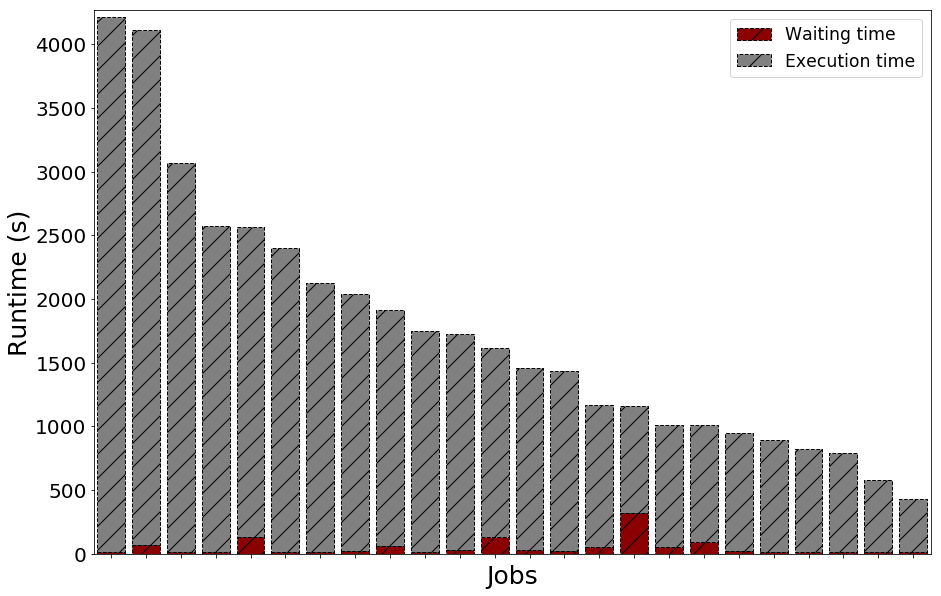

In [4]:
import os
import re
import time
import glob
import json
import tzlocal
import dateutil
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from itertools import groupby
from matplotlib import ticker
from matplotlib.font_manager import FontProperties


local_timezone = tzlocal.get_localzone()

base_dir = """/Volumes/STORAGE/Experiments/1cpu_2gb_per_executor\
/18_jobs/mesos_32MB_1cpu_2gb_dynamic_nospec_har_dir/run_two/"""

jobs_log_file = base_dir+"experiment_logs"
jobs_log_dir = base_dir+"jobs_log/"
processed_logs_dir = jobs_log_dir+"processed_logs/"
json_file_names = glob.glob(processed_logs_dir+"*.json")

output_data = []

line_to_write = '{:36s} {:15s} {:15s} {:15s} {:10s} {:10s} {:10s}'.format("App Name", "Start Time", "Allocation", "End Time", "Waiting", "Execution", "Total") 
print(line_to_write)


for fileName in json_file_names:

    data = [line.strip() for line in open(fileName, 'r')]
    
    app_name = ""
    app_start_time = ""
    first_executor_time = ""
    app_end_time = ""
    
    first_executor = False
    
    for index, line in enumerate(data):
        if "App Name" in line:
            app_name = line.strip().split("\"")[3]
        if "SparkListenerApplicationStart" in line:
            app_start_time = (data[index+1]).replace(",","").split(":")[1].strip()
        if "SparkListenerExecutorAdded" in line and not first_executor:
            
            offset = 0
            while not ("Timestamp" in data[index+offset]):
                offset = offset + 1
                
            first_executor_time = (data[index+offset]).replace(",","").split(":")[1].strip()
            first_executor = True
                
        if "SparkListenerApplicationEnd" in line:
            app_end_time = (data[index+1]).replace(",","").split(":")[1].strip()  

    local_app_start_time = datetime.fromtimestamp(float(app_start_time) / 1000.0, local_timezone)
    local_first_executor_time = datetime.fromtimestamp(float(first_executor_time) / 1000.0, local_timezone)
    local_app_end_time = datetime.fromtimestamp(float(app_end_time) / 1000.0, local_timezone)

    waiting_time = round((local_first_executor_time - local_app_start_time).total_seconds(), 3)
    execution_time = round((local_app_end_time - local_first_executor_time).total_seconds(), 3)
    total_runtime = round((waiting_time + execution_time), 3)
        
    line_to_write = '{:36s} {:15s} {:15s} {:15s} {:10s} {:10s} {:10s}'.format(app_name, app_start_time, first_executor_time, app_end_time, str(waiting_time), str(execution_time), str(total_runtime)) 
    print(line_to_write)
    output_data.append([app_name, waiting_time, execution_time, total_runtime])
    
    
N = len(output_data)

name = []
waiting = []
execution = []
total = []

for i in output_data:
    app_name = i[0].split("_")
    if app_name[0] == "imageClustering":
        #name.append("IC_"+app_name[-1])
        name.append("IC")
    if app_name[0] == "imageRestration":
    #if app_name[0] == "imageRegistration":
        #name.append("IR_"+app_name[-1])
        name.append("IR")
    if app_name[0] == "flowerCounter":
        #name.append("FC_"+app_name[-1])
        name.append("FC")        
        
    waiting.append(i[1])
    execution.append(i[2])
    total.append(i[3])
    
average_waiting_time = round(np.mean(np.array(waiting)), 3)
average_execution_time = round(np.mean(np.array(execution)), 3)
print("")
print("Average waiting time:", average_waiting_time, "sec")
print("Average execution time:", average_execution_time, "sec")
print("")


# Font of the legend
fontP = FontProperties()
fontP.set_size("xx-large")

# The x locations for the groups
ind = np.arange(N) 

data = list(np.vstack([waiting, execution]).T)
data.sort(key=lambda x: x[0]+x[1], reverse=True)
data = np.array(data)


# Plotting the bars
fig, ax = plt.subplots(figsize=(15, 10))

plot_1 = ax.bar(ind, data[:,0], color='darkred', label="Waiting time", edgecolor="k", hatch="/", ls="dashed", lw=1)
plot_2 = ax.bar(ind, data[:,1], color='gray', label="Execution time", bottom=data[:,0], edgecolor="k", hatch="/", ls="dashed", lw=1)

plt.legend(loc="best", shadow=False, ncol=1, prop=fontP)

ax.set_ylabel('Runtime (s)', fontsize=25)

ax.set_xlabel('Jobs', fontsize=25)
ax.set_xticklabels(name, fontsize=15)
ax.set_xticks(ind)

plt.yticks(fontsize=20)

plt.xlim(-0.5, N-0.5)
plt.ylim([0, max(total)+50])

fontP = FontProperties()
fontP.set_size("xx-large")

plt.show()


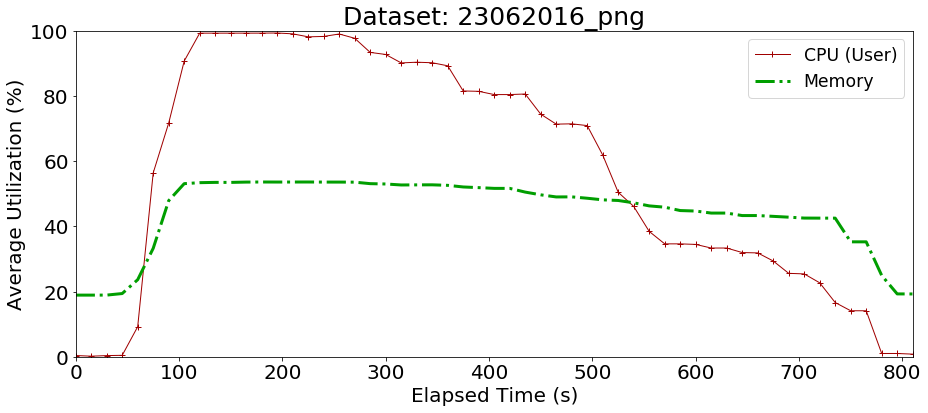

In [11]:
import os
import glob
import json
import rrdtool
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties


rrd_dir = "/Users/habib/Desktop/sparkCluster/"

exclude_dirs = ["__SummaryInfo__", "discus-p2irc-master"]

#FlowerCounter
# fetch_start_time = "1510004940" 
# fetch_end_time = "1510006440"
# graph_title = "Dataset: 15072016_1108_images12"

#ImageClustering
#fetch_start_time = "1510006680" 
#fetch_end_time = "1510007340"
#graph_title = "Dataset: 15072016_1108_images1_7_10_13"

#ImageRegistration
fetch_start_time = "1510007340" 
fetch_end_time = "1510008150"
graph_title = "Dataset: 23062016_png"


fetch_resolution = "15"

rrd_data = {}
            
for (dirpath, dirnames, filenames) in os.walk(rrd_dir):
    
    dirnames[:] = [d for d in dirnames if d not in exclude_dirs and not d[0] == '.']
    filenames = [f for f in filenames if not f[0] == '.']    
    
    for file in filenames:
        full_file_path = os.path.join(dirpath, file)
        splitted_file_path = full_file_path.split("/")
        metric_name = splitted_file_path[-2]+" "+splitted_file_path[-1]
        metric_name = metric_name[:-4]
                
        time_info,_,data = rrdtool.fetch(full_file_path, "AVERAGE", "--resolution", fetch_resolution, "--start", fetch_start_time, "--end", fetch_end_time)
        start_time = time_info[0]
        end_time = time_info[1]
        resolution = time_info[2]
        
        data_with_time_stamp = []
        current_time = start_time
        
        for data_point in data:
            current_time = current_time + resolution
            data_with_time_stamp.append((current_time, data_point[0]))
        
        rrd_data[metric_name] = data_with_time_stamp

cpu_idle = []
cpu_user = []
cpu_wio = []

mem_dict = {}

bytes_in = []
bytes_out = []

load_one = []
load_five = []
load_fifteen = []

first_entry = rrd_data[list(rrd_data.keys())[0]]
time_stamp = [datetime.fromtimestamp(int(i[0])).strftime('%Y-%m-%dT%H:%M:%S') for i in first_entry]

for k,v in rrd_data.items():
    
    data_points = np.array([i[1] for i in v], dtype=np.float64)
            
    # Getting CPU metrics
    if "cpu_idle" in k:
        cpu_idle.append(data_points)
    if "cpu_user" in k:
        cpu_user.append(data_points)
    if "cpu_wio" in k:
        cpu_wio.append(data_points)
    
    # Getting network metrics
    if "bytes_in" in k: 
        bytes_in.append(data_points/1024)
    if "bytes_out" in k:
        bytes_out.append(data_points/1024)
        
    # Getting load metrics
    if "load_one" in k:
        load_one.append(data_points)
    if "load_five" in k:
        load_five.append(data_points)
    if "load_fifteen" in k:
        load_fifteen.append(data_points)
        
    # Getting memory metrics
    if "mem_" in k:
        mem_dict[k] = data_points
        
# Calculating the percentage of memory utilization for mario
mario_total_mem = [value for key, value in mem_dict.items() if ("mario" in key and "mem_total" in key)]
mario_free_mem = [value for key, value in mem_dict.items() if ("mario" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
mario_free_mem = np.sum(np.array(mario_free_mem), axis=0)

mario_mem_stacked = np.vstack((mario_total_mem, mario_free_mem)).T
mario_percentage_mem_utilization = ((mario_mem_stacked[:,0] - mario_mem_stacked[:,1]) / mario_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for luigi
luigi_total_mem = [value for key, value in mem_dict.items() if ("luigi" in key and "mem_total" in key)]
luigi_free_mem = [value for key, value in mem_dict.items() if ("luigi" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
luigi_free_mem = np.sum(np.array(luigi_free_mem), axis=0)

luigi_mem_stacked = np.vstack((luigi_total_mem, luigi_free_mem)).T
luigi_percentage_mem_utilization = ((luigi_mem_stacked[:,0] - luigi_mem_stacked[:,1]) / luigi_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker1
worker1_total_mem = [value for key, value in mem_dict.items() if ("worker1" in key and "mem_total" in key)]
worker1_free_mem = [value for key, value in mem_dict.items() if ("worker1" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker1_free_mem = np.sum(np.array(worker1_free_mem), axis=0)

worker1_mem_stacked = np.vstack((worker1_total_mem, worker1_free_mem)).T
worker1_percentage_mem_utilization = ((worker1_mem_stacked[:,0] - worker1_mem_stacked[:,1]) / worker1_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker2
worker2_total_mem = [value for key, value in mem_dict.items() if ("worker2" in key and "mem_total" in key)]
worker2_free_mem = [value for key, value in mem_dict.items() if ("worker2" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker2_free_mem = np.sum(np.array(worker2_free_mem), axis=0)

worker2_mem_stacked = np.vstack((worker2_total_mem, worker2_free_mem)).T
worker2_percentage_mem_utilization = ((worker2_mem_stacked[:,0] - worker2_mem_stacked[:,1]) / worker2_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker3
worker3_total_mem = [value for key, value in mem_dict.items() if ("worker3" in key and "mem_total" in key)]
worker3_free_mem = [value for key, value in mem_dict.items() if ("worker3" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker3_free_mem = np.sum(np.array(worker3_free_mem), axis=0)

worker3_mem_stacked = np.vstack((worker3_total_mem, worker3_free_mem)).T
worker3_percentage_mem_utilization = ((worker3_mem_stacked[:,0] - worker3_mem_stacked[:,1]) / worker3_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker4
worker4_total_mem = [value for key, value in mem_dict.items() if ("worker4" in key and "mem_total" in key)]
worker4_free_mem = [value for key, value in mem_dict.items() if ("worker4" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker4_free_mem = np.sum(np.array(worker4_free_mem), axis=0)

worker4_mem_stacked = np.vstack((worker4_total_mem, worker4_free_mem)).T
worker4_percentage_mem_utilization = ((worker4_mem_stacked[:,0] - worker4_mem_stacked[:,1]) / worker4_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker5
worker5_total_mem = [value for key, value in mem_dict.items() if ("worker5" in key and "mem_total" in key)]
worker5_free_mem = [value for key, value in mem_dict.items() if ("worker5" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker5_free_mem = np.sum(np.array(worker5_free_mem), axis=0)

worker5_mem_stacked = np.vstack((worker5_total_mem, worker5_free_mem)).T
worker5_percentage_mem_utilization = ((worker5_mem_stacked[:,0] - worker5_mem_stacked[:,1]) / worker5_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker6
worker6_total_mem = [value for key, value in mem_dict.items() if ("worker6" in key and "mem_total" in key)]
worker6_free_mem = [value for key, value in mem_dict.items() if ("worker6" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker6_free_mem = np.sum(np.array(worker6_free_mem), axis=0)

worker6_mem_stacked = np.vstack((worker6_total_mem, worker6_free_mem)).T
worker6_percentage_mem_utilization = ((worker6_mem_stacked[:,0] - worker6_mem_stacked[:,1]) / worker6_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker7
worker7_total_mem = [value for key, value in mem_dict.items() if ("worker7" in key and "mem_total" in key)]
worker7_free_mem = [value for key, value in mem_dict.items() if ("worker7" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker7_free_mem = np.sum(np.array(worker7_free_mem), axis=0)

worker7_mem_stacked = np.vstack((worker7_total_mem, worker7_free_mem)).T
worker7_percentage_mem_utilization = ((worker7_mem_stacked[:,0] - worker7_mem_stacked[:,1]) / worker7_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker8
worker8_total_mem = [value for key, value in mem_dict.items() if ("worker8" in key and "mem_total" in key)]
worker8_free_mem = [value for key, value in mem_dict.items() if ("worker8" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker8_free_mem = np.sum(np.array(worker8_free_mem), axis=0)

worker8_mem_stacked = np.vstack((worker8_total_mem, worker8_free_mem)).T
worker8_percentage_mem_utilization = ((worker8_mem_stacked[:,0] - worker8_mem_stacked[:,1]) / worker8_mem_stacked[:,0]) * 100

# Calculating the percentage of memory utilization for worker9
worker9_total_mem = [value for key, value in mem_dict.items() if ("worker9" in key and "mem_total" in key)]
worker9_free_mem = [value for key, value in mem_dict.items() if ("worker9" in key and ("mem_buffers" in key or "mem_cached" in key or "mem_free" in key))]
worker9_free_mem = np.sum(np.array(worker9_free_mem), axis=0)

worker9_mem_stacked = np.vstack((worker9_total_mem, worker9_free_mem)).T
worker9_percentage_mem_utilization = ((worker9_mem_stacked[:,0] - worker9_mem_stacked[:,1]) / worker9_mem_stacked[:,0]) * 100

percent_mem_util = [mario_percentage_mem_utilization, luigi_percentage_mem_utilization, worker1_percentage_mem_utilization,
                   worker2_percentage_mem_utilization, worker3_percentage_mem_utilization, worker4_percentage_mem_utilization,
                   worker5_percentage_mem_utilization, worker6_percentage_mem_utilization, worker7_percentage_mem_utilization,
                   worker8_percentage_mem_utilization, worker9_percentage_mem_utilization]

cpu_idle = np.average(np.array(cpu_idle).T, 1)
cpu_user = np.average(np.array(cpu_user).T, 1)
cpu_wio = np.average(np.array(cpu_wio).T, 1)

percent_cpu_util = cpu_user 
#percent_cpu_util = cpu_user + cpu_wio + cpu_idle
percent_mem_util = np.average(np.array(percent_mem_util).T, axis=1)

mem_free = 100 - percent_mem_util

bytes_in = np.average(np.array(bytes_in).T, 1)
bytes_out = np.average(np.array(bytes_out).T, 1)

load_one = np.average(np.array(load_one).T, 1)
load_five = np.average(np.array(load_five).T, 1)
load_fifteen = np.average(np.array(load_fifteen).T, 1)

time_stamp_in_num = [0]
formated_time_stamp = []

for t in time_stamp:
    formated_time_stamp.append(datetime.strptime(t, "%Y-%m-%dT%H:%M:%S"))

first_time_stamp = formated_time_stamp[0]

for index in range(1, len(formated_time_stamp)):
    current_time_stamp = formated_time_stamp[index]
    sec_difference = (current_time_stamp - first_time_stamp).total_seconds()
    time_stamp_in_num.append(sec_difference)   
    
time_stamp_in_num = np.array(time_stamp_in_num)

# Font of the legend
fontP = FontProperties()
fontP.set_size("xx-large")

############## CPU and Memory Utilization ##############
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(time_stamp_in_num, percent_cpu_util, '-+', color="#a00000", label="CPU (User)", lw=1)
ax.plot(time_stamp_in_num, percent_mem_util, '-.', color="#009e00", label="Memory", lw=3)

font = {'family':'serif', 'color':'darkred', 'weight':'normal', 'size':20}

plt.title(graph_title, fontsize=25)
plt.yticks(fontsize=20)
plt.ylabel("Average Utilization (%)", fontsize=20)
plt.ylim(0, 100)

plt.xticks(fontsize=20)
plt.xlabel("Elapsed Time (s)", fontsize=20)
plt.xlim(0, max(time_stamp_in_num))

plt.legend(loc="best", shadow=False, ncol=1, prop=fontP)
#ax.yaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)
#ax.xaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)

figure_name = "/Users/habib/Desktop/flowerCounter_resource_requirement.pdf"
plt.savefig(figure_name, format='pdf', dpi=1200)
plt.show()


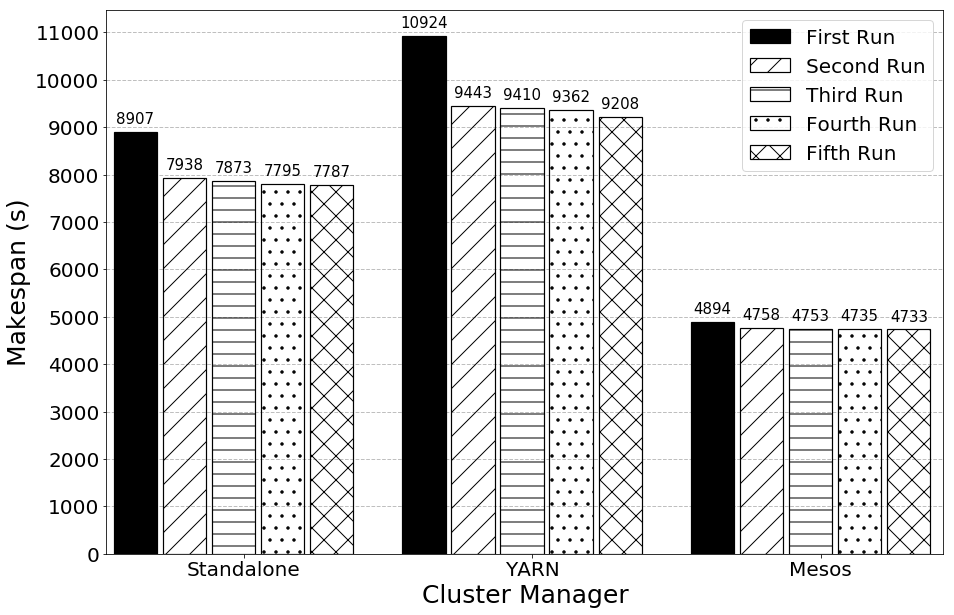

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


# First run and subsequent runs makespan
raw_data = {'job_name': ['Standalone', 'YARN', 'Mesos'], #x-axis
            'First Run': [8907, 10924, 4894], #y-axis
            'Second Run': [7938, 9443, 4758], 
            'Third Run': [7873, 9410, 4753], 
            'Fourth Run': [7795, 9362, 4735], 
            'Fifth Run': [7787, 9208, 4733]}

df = pd.DataFrame(raw_data, columns=['job_name', 'First Run', 'Second Run', 'Third Run', 'Fourth Run', 'Fifth Run'])

"""
YARN_std = (np.std([10924, 9443, 9410, 9362, 9208]))/np.sqrt(5)
standalone_std = (np.std([8907, 7938, 7873, 7795, 7787]))/np.sqrt(5)
mesos_std = (np.std([4894, 4758, 4753, 4735, 4733]))/np.sqrt(5)

all_std = [YARN_std, standalone_std, mesos_std]
"""

# Setting the positions and width for the bars
pos = list(range(len(df['First Run'])))
width = 0.15

# Plotting the bars
fig, ax = plt.subplots(figsize=(15, 10))

bar1 = plt.bar(pos, df['First Run'], width, color='black', edgecolor="k", lw=1.2, error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
bar2 = plt.bar([p + width + 0.02 for p in pos], df['Second Run'], width, color='none', hatch="/", edgecolor="k", ls="solid", lw=1.2, error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
bar3 = plt.bar([p + (width * 2) + 0.04 for p in pos], df['Third Run'], width, color='none', hatch="-", edgecolor="k", ls="solid",lw=1.2, error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
bar4 = plt.bar([p + (width * 3) + 0.06 for p in pos], df['Fourth Run'], width, color='none', hatch=".", edgecolor="k", ls="solid", lw=1.2, error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
bar5 = plt.bar([p + (width * 4) + 0.08 for p in pos], df['Fifth Run'], width, color='none', hatch="x", edgecolor="k", ls="solid",lw=1.2, error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))

#ax.set_title('Static Vs Dynamic resource allocation on standalone cluster manager (No speculative execution of tasks)', fontsize=20)
ax.set_ylabel('Makespan (s)', fontsize=25)
ax.set_xticklabels(df['job_name'], fontsize=20)
ax.set_xticks([p + 2.5 * width for p in pos])
ax.set_xlabel('Cluster Manager', fontsize=25)

plt.xlim(-0.1, 2.80)
plt.yticks(np.arange(0, 12000, step=1000), fontsize=20)

fontP = FontProperties()
fontP.set_size("xx-large")

plt.legend(['First Run', 'Second Run', 'Third Run', 'Fourth Run', 'Fifth Run'], loc='best', fontsize=20)
#plt.title('Figure title', fontsize=25)

ax.set_axisbelow(True)
#ax.grid(color='#bfbfbf', linestyle='--', linewidth=1)
ax.yaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)


def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()
        label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position, '%d' % int(height), ha='center', va='bottom', fontsize=15)


autolabel(bar1, ax)
autolabel(bar2, ax)
autolabel(bar3, ax)
autolabel(bar4, ax)
autolabel(bar5, ax)

plt.savefig('/Users/habib/Desktop/first_run_subsequent_run_makespan_comparison_bar.pdf', format='pdf', dpi=10000)

plt.show()

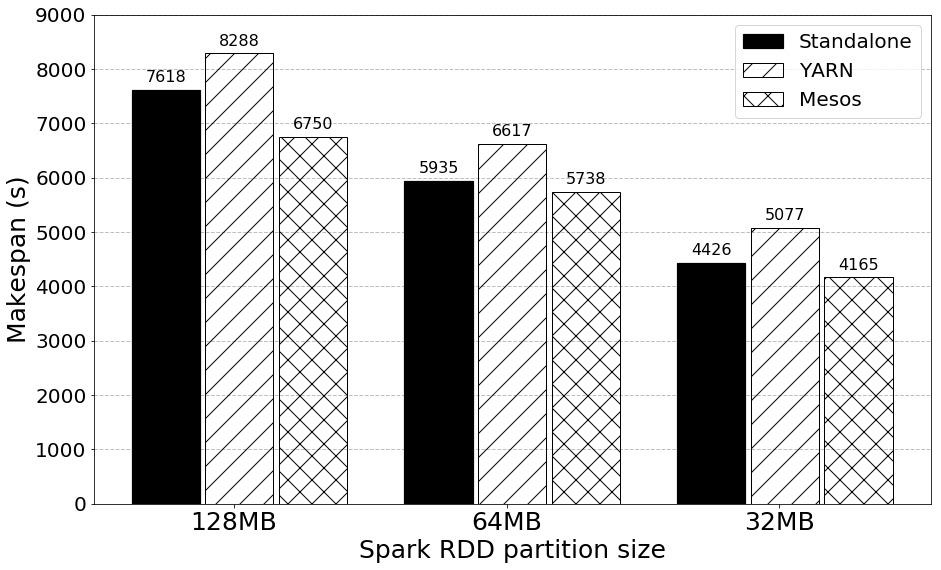

In [47]:
# Author: Habib Sabiu
# Date: March 31, 2017
# Purpose: Script to plot nice graphs for comparing jobs makespan
# Copyright: Any person can adopt this script for their specific need

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


"""
# Static resource allocation: 1cpu, 2gb, no speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            'Standalone': [20636, 16084, 8170], #y-axis
            'YARN': [12562, 12007, 9626], 
            'Mesos': [9428, 6133, 4753]}
"""

# Dynamic resource allocation: 1cpu, 2gb, no speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            'Standalone': [7618, 5935, 4426], #y-axis
            'YARN': [8288, 6617, 5077],
            'Mesos': [6750, 5738, 4165]}


df = pd.DataFrame(raw_data, columns=['job_name', 'Standalone', 'YARN', 'Mesos'])

# Setting the positions and width for the bars
pos = list(range(len(df['Standalone'])))
width = 0.25

# Plotting the bars
fig, ax = plt.subplots(figsize=(15, 9))
plt.rcParams["patch.force_edgecolor"] = True

bar1 = ax.bar(pos, df['Standalone'], width, color='black', edgecolor="k", lw=1.2)
bar2 = ax.bar([p + width + 0.02 for p in pos], df['YARN'], width, color='none', hatch="/", edgecolor="k", ls="solid", lw=1)
bar3 = ax.bar([p + (width * 2) + 0.04 for p in pos], df['Mesos'], width, color='none', hatch="x", edgecolor="k", ls="solid",lw=1)

#ax.set_title('Dynamic Resource Allocation Makespan', fontsize=25)
ax.set_ylabel('Makespan (s)', fontsize=25)
ax.set_xticklabels(df['job_name'], fontsize=25)
ax.set_xticks([p + 1 * width for p in pos])
ax.set_xlabel('Spark RDD partition size', fontsize=25)

plt.yticks(np.arange(0, 10000, step=1000), fontsize=20)

#plt.xlim(-0.2, 2.85)
#plt.ylim([0, 1700])

fontP = FontProperties()
fontP.set_size("xx-large")

#plt.legend(['Standalone', 'YARN', 'Mesos'], loc="best", shadow=False, ncol=1, prop=fontP)
plt.legend(['Standalone', 'YARN', 'Mesos'], loc="best", shadow=False, ncol=1, fontsize=20)

ax.set_axisbelow(True)
#ax.grid(color='#bfbfbf', linestyle='--', linewidth=1)
ax.yaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)


def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()
        label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position, '%d' % int(height), ha='center', va='bottom', fontsize=16)

autolabel(bar1, ax)
autolabel(bar2, ax)
autolabel(bar3, ax)

plt.savefig('/Users/habib/Desktop/runtime_dynamic_1cpu_2gb_nospeculation_1.pdf', format='pdf', dpi=10000)

plt.show() 

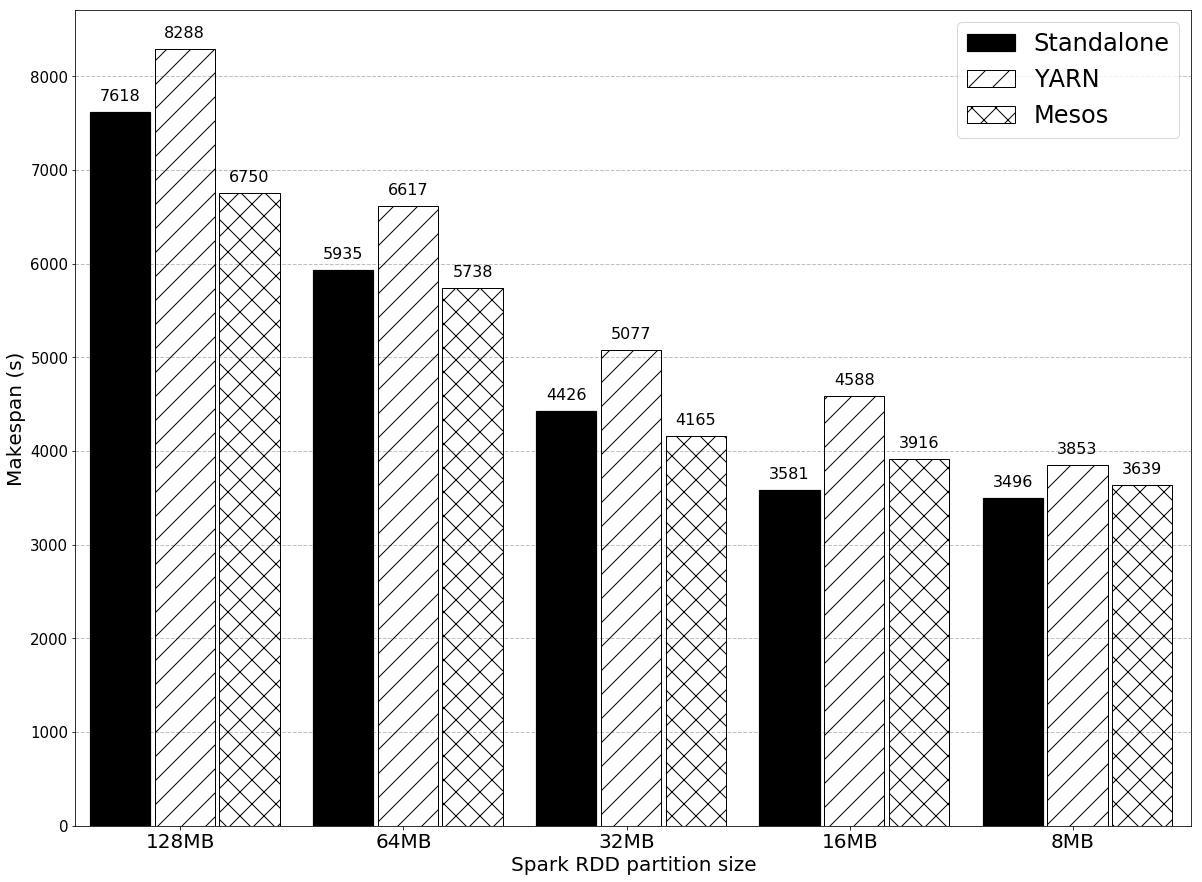

In [44]:
# Author: Habib Sabiu
# Date: March 31, 2017
# Purpose: Script to plot nice graphs for comparing jobs makespan
# Copyright: Any person can adopt this script for their specific need

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


"""
# Static resource allocation: 1cpu, 2gb, no speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB', '16MB', '8MB'], #x-axis
            'Standalone': [20636, 16084, 8170, 5714, 4920], #y-axis
            'YARN': [12562, 12007, 9626, 9199, 8189],
            'Mesos': [9428, 6133, 4753, 4336, 3890]}
"""

# Dynamic resource allocation: 1cpu, 2gb, no speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB', '16MB', '8MB'], #x-axis
            'Standalone': [7618, 5935, 4426, 3581, 3496], #y-axis
            'YARN': [8288, 6617, 5077, 4588, 3853],
            'Mesos': [6750, 5738, 4165, 3916, 3639]}


df = pd.DataFrame(raw_data, columns=['job_name', 'Standalone', 'YARN', 'Mesos'])

# Setting the positions and width for the bars
pos = list(range(len(df['Standalone'])))
width = 0.27

# Plotting the bars
fig, ax = plt.subplots(figsize=(20, 15))

bar1 = plt.bar(pos, df['Standalone'], width, color='black', edgecolor="k", lw=1.2)
bar2 = plt.bar([p + width + 0.02 for p in pos], df['YARN'], width, color='none', hatch="/", edgecolor="k", ls="solid", lw=1)
bar3 = plt.bar([p + (width * 2) + 0.04 for p in pos], df['Mesos'], width, color='none', hatch="x", edgecolor="k", ls="solid",lw=1)

#ax.set_title('Dynamic Resource Allocation Makespan', fontsize=25)

ax.set_ylabel('Makespan (s)', fontsize=20)
plt.yticks(fontsize=15)

ax.set_xticklabels(df['job_name'], fontsize=20)
ax.set_xticks([p + 1 * width for p in pos])

ax.set_xlabel('Spark RDD partition size', fontsize=20)

plt.xlim(-0.2, 4.8)
#plt.ylim([0, 1700])

fontP = FontProperties()
fontP.set_size("xx-large")

plt.legend(['Standalone', 'YARN', 'Mesos'], loc="best", shadow=False, ncol=1, fontsize=24)

ax.set_axisbelow(True)
#ax.grid(color='#bfbfbf', linestyle='--', linewidth=1)
ax.yaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)


def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()
        label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position, '%d' % int(height), ha='center', va='bottom', fontsize=16)

autolabel(bar1, ax)
autolabel(bar2, ax)
autolabel(bar3, ax)

plt.savefig('/Users/habib/Desktop/runtime_dynamic_1cpu_2gb_nospeculation_2.pdf', format='pdf', dpi=10000)

plt.show() 

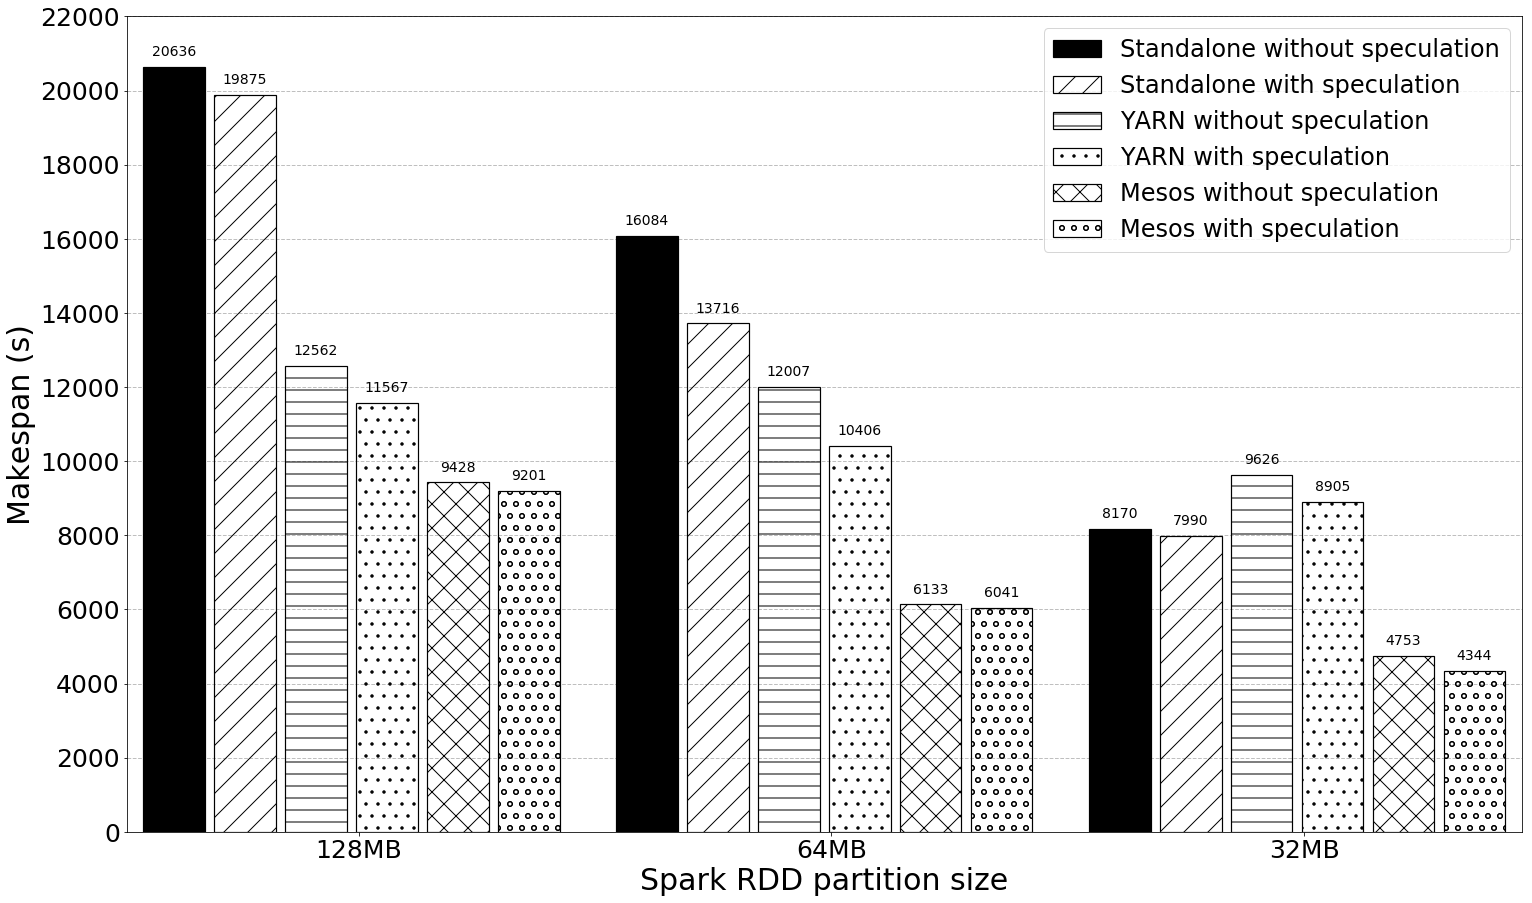

In [66]:
# Author: Habib Sabiu
# Date: March 31, 2017
# Purpose: Script to plot nice graphs for comparing jobs makespan
# Copyright: Any person can adopt this script for their specific need

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


# Static speculation Vs static no speculation: 1cpu 2gb
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            'Standalone without speculation': [20636, 16084, 8170], #y-axis
            'Standalone with speculation': [19875, 13716, 7990], 
            'YARN without speculation': [12562, 12007, 9626], 
            'YARN with speculation': [11567, 10406, 8905], 
            'Mesos without speculation': [9428, 6133, 4753], 
            'Mesos with speculation': [9201, 6041, 4344]}

"""
# Dynamic speculation Vs dynamic no speculation: 1cpu 2gb
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            'Standalone without speculation': [7618, 5935, 4426], #y-axis
            'Standalone with speculation': [6871, 5266, 4607], 
            'YARN without speculation': [8288, 6617, 5077], 
            'YARN with speculation': [7407, 5920, 4607], 
            'Mesos without speculation': [6750, 5738, 4165], 
            'Mesos with speculation': [6483, 5561, 4146]}
"""

df = pd.DataFrame(raw_data, columns=['job_name', 'Standalone without speculation', 'Standalone with speculation', 'YARN without speculation', 'YARN with speculation', 'Mesos without speculation', 'Mesos with speculation'])

# Setting the positions and width for the bars
pos = list(range(len(df['Standalone without speculation'])))
width = 0.13

# Plotting the bars
fig, ax = plt.subplots(figsize=(25, 15))

bar1 = plt.bar(pos, df['Standalone without speculation'], width, color='black', edgecolor="k", lw=1.2)
bar2 = plt.bar([p + width + 0.02 for p in pos], df['Standalone with speculation'], width, color='none', hatch="/", edgecolor="k", ls="solid", lw=1.2)
bar3 = plt.bar([p + (width * 2) + 0.04 for p in pos], df['YARN without speculation'], width, color='none', hatch="-", edgecolor="k", ls="solid",lw=1.2)
bar4 = plt.bar([p + (width * 3) + 0.06 for p in pos], df['YARN with speculation'], width, color='none', hatch=".", edgecolor="k", ls="solid", lw=1.2)
bar5 = plt.bar([p + (width * 4) + 0.08 for p in pos], df['Mesos without speculation'], width, color='none', hatch="x", edgecolor="k", ls="solid",lw=1.2)
bar6 = plt.bar([p + (width * 5) + 0.10 for p in pos], df['Mesos with speculation'], width, color='none', hatch="o", edgecolor="k", ls="solid", lw=1.2)

#ax.set_title('Static Vs Dynamic resource allocation on standalone cluster manager (No speculative execution of tasks)', fontsize=20)

ax.set_ylabel('Makespan (s)', fontsize=30)
plt.yticks(fontsize=15)

ax.set_xticklabels(df['job_name'], fontsize=25)
ax.set_xticks([p + 3 * width for p in pos])
ax.set_xlabel('Spark RDD partition size', fontsize=30)

plt.xlim(-0.1, 2.85)
#plt.ylim([0, 1200])
plt.yticks(np.arange(0, 23000, step=2000), fontsize=25) # For static resource allocation data
#plt.yticks(np.arange(0, 10000, step=1000), fontsize=25) # For dynamic resource allocation data

fontP = FontProperties()
fontP.set_size("xx-large")

plt.legend(['Standalone without speculation', 'Standalone with speculation', 'YARN without speculation', 'YARN with speculation', 'Mesos without speculation', 'Mesos with speculation'], loc='best', fontsize=24)

ax.set_axisbelow(True)
#ax.grid(color='#bfbfbf', linestyle='--', linewidth=1)
ax.yaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)


def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()
        label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position, '%d' % int(height), ha='center', va='bottom', fontsize=14)


autolabel(bar1, ax)
autolabel(bar2, ax)
autolabel(bar3, ax)
autolabel(bar4, ax)
autolabel(bar5, ax)
autolabel(bar6, ax)

plt.savefig('/Users/habib/Desktop/runtime_static_1cpu_2gb_speculationVsnospeculation.pdf', format='pdf', dpi=10000)

plt.show()

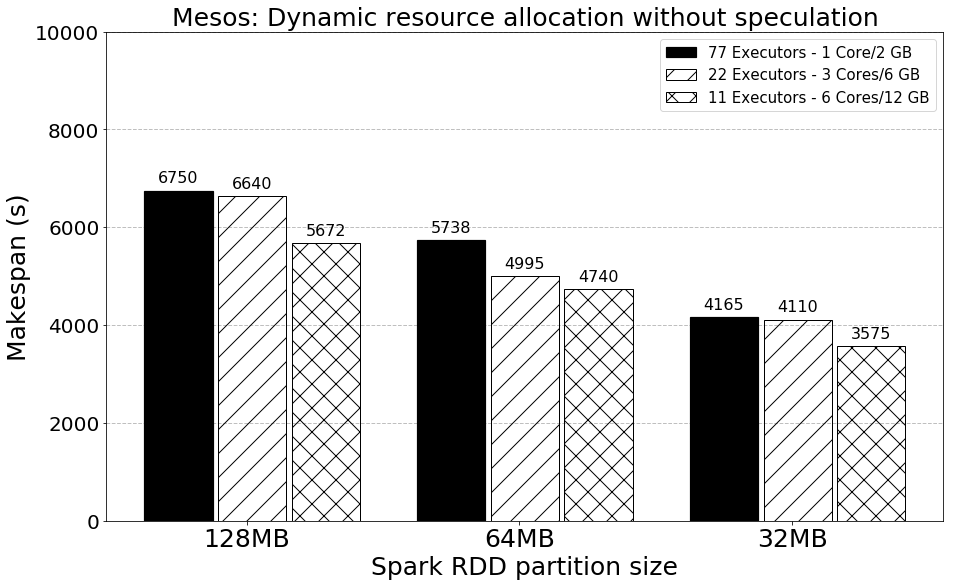

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


"""
# Standalone makespan static without speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            '1 CPU Core, 2 GB Memory': [20636, 16084, 8170], #y-axis
            '3 CPU Core, 6 GB Memory': [19336, 12918, 7271],
            '6 CPU Core, 12 GB Memory': [16900, 11563, 7056]}

# Standalone makespan dynamic without speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            '1 CPU Core, 2 GB Memory': [7618, 5935, 4426], #y-axis
            '3 CPU Core, 6 GB Memory': [7187, 5332, 4268],
            '6 CPU Core, 12 GB Memory': [8459, 6257, 5452]}

# Mesos makespan static without speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            '1 CPU Core, 2 GB Memory': [9428, 6133, 4753], #y-axis
            '3 CPU Core, 6 GB Memory': [7740, 5467, 4560],
            '6 CPU Core, 12 GB Memory': [9062, 5852, 4598]}

"""
# Mesos makespan dynamic without speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            '1 CPU Core, 2 GB Memory': [6750, 5738, 4165], #y-axis
            '3 CPU Core, 6 GB Memory': [6640, 4995, 4110],
            '6 CPU Core, 12 GB Memory': [5672, 4740, 3575]}

"""
# YARN makespan static without speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            '1 CPU Core, 2 GB Memory': [12562, 12007, 9626], #y-axis
            '3 CPU Core, 6 GB Memory': [9352, 6581, 6487],
            '6 CPU Core, 12 GB Memory': [8014, 7736, 5793]}

# YARN makespan dynamic without speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            '1 CPU Core, 2 GB Memory': [8288, 6617, 5077], #y-axis
            '3 CPU Core, 6 GB Memory': [6627, 5763, 4703],
            '6 CPU Core, 12 GB Memory': [5576, 5197, 5069]}





# Standalone makespan static with speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            '1 CPU Core, 2 GB Memory': [19875, 13716, 7990], #y-axis
            '3 CPU Core, 6 GB Memory': [21016, 11210, 7407],
            '6 CPU Core, 12 GB Memory': [25163, 13709, 8343]}

# Standalone makespan dynamic with speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            '1 CPU Core, 2 GB Memory': [6871, 5266, 4607], #y-axis
            '3 CPU Core, 6 GB Memory': [5705, 6728, 4371],
            '6 CPU Core, 12 GB Memory': [8644, 6104, 6093]}
            
# Mesos makespan static with speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            '1 CPU Core, 2 GB Memory': [9201, 6041, 4344], #y-axis
            '3 CPU Core, 6 GB Memory': [10999, 7173, 4560],
            '6 CPU Core, 12 GB Memory': [10233, 12754, 4928]}

# Mesos makespan dynamic with speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            '1 CPU Core, 2 GB Memory': [6483, 5561, 4146], #y-axis
            '3 CPU Core, 6 GB Memory': [5841, 6203, 4406],
            '6 CPU Core, 12 GB Memory': [11493, 10903, 6171]}
            
# YARN makespan static with speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            '1 CPU Core, 2 GB Memory': [11567, 10406, 8905], #y-axis
            '3 CPU Core, 6 GB Memory': [9557, 7082, 6963],
            '6 CPU Core, 12 GB Memory': [9138, 6899, 6258]}
            
# YARN makespan dynamic with speculation 
raw_data = {'job_name': ['128MB', '64MB', '32MB'], #x-axis
            '1 CPU Core, 2 GB Memory': [7407, 5920, 4607], #y-axis
            '3 CPU Core, 6 GB Memory': [7500, 6494, 5022],
            '6 CPU Core, 12 GB Memory': [7276, 6065, 5852]}
"""


df = pd.DataFrame(raw_data, columns=['job_name', '1 CPU Core, 2 GB Memory', '3 CPU Core, 6 GB Memory', '6 CPU Core, 12 GB Memory'])

# Setting the positions and width for the bars
pos = list(range(len(df['1 CPU Core, 2 GB Memory'])))
width = 0.25

# Plotting the bars
fig, ax = plt.subplots(figsize=(15, 9))
plt.rcParams["patch.force_edgecolor"] = True

bar1 = ax.bar(pos, df['1 CPU Core, 2 GB Memory'], width, color='black', edgecolor="k", lw=1.2)
bar2 = ax.bar([p + width + 0.02 for p in pos], df['3 CPU Core, 6 GB Memory'], width, color='none', hatch="/", edgecolor="k", ls="solid", lw=1)
bar3 = ax.bar([p + (width * 2) + 0.04 for p in pos], df['6 CPU Core, 12 GB Memory'], width, color='none', hatch="x", edgecolor="k", ls="solid",lw=1)

ax.set_ylabel('Makespan (s)', fontsize=25)
ax.set_xticklabels(df['job_name'], fontsize=25)
ax.set_xticks([p + 1 * width for p in pos])
ax.set_xlabel('Spark RDD partition size', fontsize=25)

plt.yticks(np.arange(0, 10100, step=2000), fontsize=20)
plt.title('Mesos: Dynamic resource allocation without speculation', fontsize=25)

#plt.xlim(-0.2, 2.85)
#plt.ylim([0, 1700])

fontP = FontProperties()
fontP.set_size("xx-large")

plt.legend(['77 Executors - 1 Core/2 GB', '22 Executors - 3 Cores/6 GB', '11 Executors - 6 Cores/12 GB'], loc="best", shadow=False, ncol=1, fontsize=15)

ax.set_axisbelow(True)
#ax.grid(color='#bfbfbf', linestyle='--', linewidth=1)
ax.yaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)


def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()
        label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position, '%d' % int(height), ha='center', va='bottom', fontsize=16)

autolabel(bar1, ax)
autolabel(bar2, ax)
autolabel(bar3, ax)

plt.savefig('/Users/habib/Desktop/makespan_mesos_dynamic_withoutspeculation_different_resource_size.pdf', format='pdf', dpi=10000)

plt.show() 

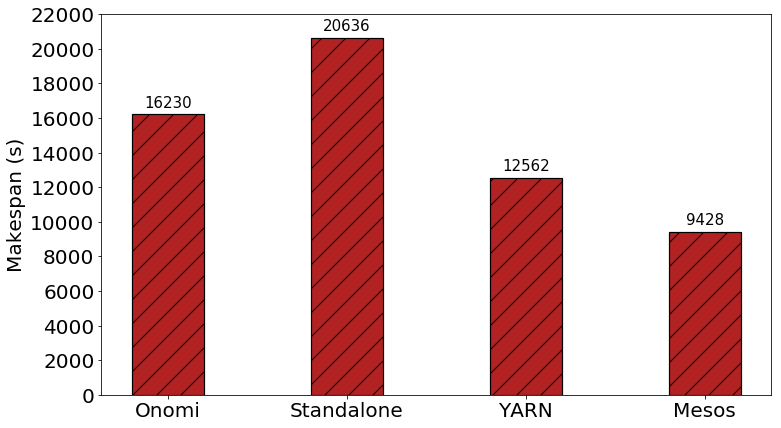

In [4]:
import numpy as np
import matplotlib.pyplot as plt


"""
# Comparing best makespan results of Onomi (56 cores) and Spark (56 cores)
onomi_makespan = 16230
standalone_makespan = 6086
yarn_makespan = 6981
mesos_makespan = 5727

# Comparing elapsed time/56 cores - Onomi (56 cores) and Spark (56 cores)
onomi_makespan = 290
standalone_makespan = 109
yarn_makespan = 125
mesos_makespan = 102

# Comparing makespan/GB - Onomi (56 cores) and Spark (56 cores)
onomi_makespan = 1673
standalone_makespan = 627
yarn_makespan = 720
mesos_makespan = 590
"""

# Onomi and Spark (with all default values) 
onomi_makespan = 16230
standalone_makespan = 20636
mesos_makespan = 9428
yarn_makespan = 12562


makespan_data = (onomi_makespan, standalone_makespan, yarn_makespan, mesos_makespan)

N = len(makespan_data)

ind = np.arange(N)    # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(12, 7))
#ax.yaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)

#bar1 = plt.bar(ind, makespan_data, width, color='none', hatch="o", edgecolor="k", ls="solid", lw=1.2)
bar1 = plt.bar(ind, makespan_data, width, color='firebrick', hatch="/", edgecolor="k", ls="solid", lw=1.2)

plt.yticks(fontsize=15)
plt.ylabel('Makespan (s)', fontsize=20)
#plt.title('Static Resource Allocation: 1 CPU core, 2 GB', fontsize=20)
plt.xticks(ind, ('Onomi', 'Standalone', 'YARN', 'Mesos'), fontsize=20)
plt.yticks(np.arange(0, 24000, step=2000), fontsize=20)

def autolabel(rects, ax):
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()
        label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position, '%d' % int(height), ha='center', va='bottom', fontsize=15)
        
autolabel(bar1, ax)

plt.savefig('/Users/habib/Desktop/makespan_default_with_onomi.pdf', format='pdf', dpi=10000)

plt.show()

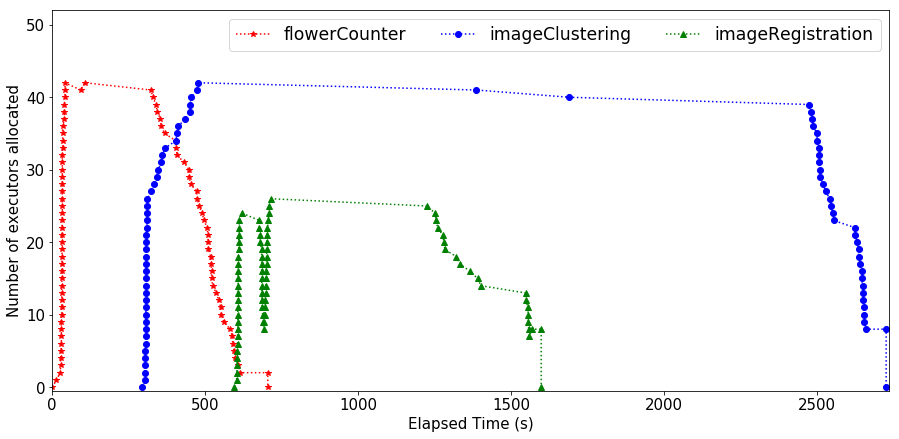

In [493]:
# Application name: plotEventsStandalone

# Author: Habib Sabiu
# Date: March 31, 2017
# Purpose: Script to process Spark log files generated when running Spark applications on the
#          Standalone cluster manager. This script would loop through all the log files in the
#          current directory and get the timestamp for all events specified within 'events' list.
#          Basically, the events of interest here are the number of executors added or remove
#          from an application over time. The x-axis shows the elapsed time while the y-axis
#          shows the count of the executors used by the application at the given time stamp.
#          The script will only process and compare the log files of 5 applications at a time
# Copyright: Any person can adopt this script for their specific need as long as credit is given
#            to the initial author

from datetime import datetime
from itertools import groupby
from matplotlib import ticker
from matplotlib.font_manager import FontProperties

import os
import re
import glob
import json
import tzlocal
import dateutil
import matplotlib.pyplot as plt


eventsFileName = "events_log_record.txt"
events = ["SparkListenerApplicationStart", "SparkListenerExecutorAdded", "SparkListenerExecutorRemoved", "SparkListenerApplicationEnd"]

local_timezone = tzlocal.get_localzone()
intermediateLines = []

x_axis = []
y_axis = []

eventLine = ""
currentFileName = ""

input_logs_dir = "/Users/habib/Desktop/Thesis/Experiments/Proposal/Standalone/experiment_8/"
processed_logs_dir = input_logs_dir+"processed_logs/"

# Create output directory if it does not already exist
if not os.path.exists(processed_logs_dir):
    os.makedirs(processed_logs_dir)

# Get all file names in the working directory
all_files = glob.glob(input_logs_dir+"*")

# Filter the files that have .txt, .py, .png, .jpg extension.
# This leaves us with only the log files which don't have any extension
log_files_name = [file for file in all_files if not "." in file and not os.path.isdir(file)]

for fileName in log_files_name:
    # A list to hold the parsed json
    parsedLogFile = []
    with open(fileName) as logFile:
        fileName = fileName.split("/")[-1]
        for jsonLine in logFile:
            try:
                # Parse each json line by line
                parsedLogFile.append(json.loads(jsonLine))
            except: 
                pass
        
        # Print the parsed json with indentation of 4
        jsonFormatted = json.dumps(parsedLogFile, indent=4, sort_keys=True)

        # Add .json format to the original log filename
        jsonFormatedLogFileName = fileName+".json"

        # Delete the json file if it already exist in the directory
        try:
            os.remove(jsonFormatedLogFileName)
        except OSError:
            pass

        # Save the a copy of the original logfile as a formatted json file
        f = open(processed_logs_dir+jsonFormatedLogFileName, 'w')
        print(jsonFormatted, file=f)
        f.close()

json_file_names = glob.glob(processed_logs_dir+"*.json")

for fileName in json_file_names:
    with open(fileName) as logFile:
        fileName = fileName.split("/")[-1]
        fileName = fileName.replace(".json", "")
        for line in logFile:
            if any(s in line for s in events):
                eventLine = "\"App\":" + fileName + " " + line.replace(",", "").strip()
                currentFileName = fileName
            if "Timestamp" in line and eventLine != "" and currentFileName == fileName:
                intermediateLines.append(eventLine)
                intermediateLines.append("\"App\":" + fileName + " " + line.replace(",", "").strip())
                eventLine = ""

executorsCounter = 0
previousAppName = ""

listLength = len(intermediateLines)

with open(processed_logs_dir+eventsFileName, 'w') as eventsFile:
    for index, line in enumerate(intermediateLines):
        if "Event" in line:
            if not index + 3 > listLength:
                currentEventTime = intermediateLines[index + 1]
                nextEvent = intermediateLines[index + 2]
                nextEventTime = intermediateLines[index + 3]

                currentEventTimeList = re.findall(r'\S+', currentEventTime)
                nextEventTimeList = re.findall(r'\S+', nextEventTime)

                currentEventTimeStampFloat = float(currentEventTimeList[2])
                nextEventTimeStampFloat = float(nextEventTimeList[2])

                current_event_local_time = datetime.fromtimestamp(currentEventTimeStampFloat / 1000.0, local_timezone)
                next_event_local_time = datetime.fromtimestamp(nextEventTimeStampFloat / 1000.0, local_timezone)

                currentEventTimestampToLocal = str(current_event_local_time.strftime("%Y-%b-%d %H:%M:%S"))
                nextEventTimestampToLocal = str(next_event_local_time.strftime("%Y-%b-%d %H:%M:%S"))

                intermediateTimeStamp = current_event_local_time
                intermediateTimeStamp = str(intermediateTimeStamp.strftime("%Y-%b-%d %H:%M:%S"))

                appName = currentEventTimeList[0][6:]
                event = line[40:len(line) - 1]

                if previousAppName == "":
                    previousAppName = appName

                if appName == previousAppName:
                    if event == "SparkListenerApplicationStart":
                        executorsCounter = 0
                    elif event == "SparkListenerExecutorAdded":
                        executorsCounter += 1
                    elif event == "SparkListenerExecutorRemoved":
                        executorsCounter -= 1
                    elif event == "SparkListenerApplicationEnd":
                        executorsCounter = 0
                else:
                    previousAppName = ""
                    executorsCounter = 0
                    x_axis.append("")
                    y_axis.append("")

                lineToWrite = (line.replace(",", "").strip() + " Timestamp: " + currentEventTimeList[2] + " Current Time: " + currentEventTimestampToLocal + " Next Time: " + nextEventTimestampToLocal + " NumExecutors: " + str(executorsCounter)).replace("\"", "")
                y_axis.append(executorsCounter)
                x_axis.append(currentEventTimestampToLocal)
                eventsFile.write(lineToWrite + "\n")

                if "SparkListenerApplicationEnd" in nextEvent:
                    lineToWrite = (line.replace(",", "").strip() + " Timestamp: " + currentEventTimeList[2] + " Current Time: " + currentEventTimestampToLocal + " Next Time: " + nextEventTimestampToLocal + " NumExecutors: " + str(executorsCounter)).replace("\"", "")
                    y_axis.append(executorsCounter)
                    x_axis.append(nextEventTimestampToLocal)
                    eventsFile.write(lineToWrite + "\n")

            else:
                lastEventTime = intermediateLines[index + 1]
                lastEventTimeList = re.findall(r'\S+', lastEventTime)
                lastEventTimeStampFloat = float(lastEventTimeList[2])
                last_event_local_time = datetime.fromtimestamp(lastEventTimeStampFloat / 1000.0, local_timezone)
                lastEventTimestampToLocal = str(last_event_local_time.strftime("%Y-%b-%d %H:%M:%S"))

                lineToWrite = (line.replace(",", "").strip() + " Timestamp: " + lastEventTimeList[2] + " Current Time: " + lastEventTimestampToLocal + " Next Time: " + lastEventTimestampToLocal + " NumExecutors: 0").replace("\"", "")
                y_axis.append(0)
                x_axis.append(lastEventTimestampToLocal)
                eventsFile.write(lineToWrite + "\n")


timeStampList = [list(group) for k, group in groupby(x_axis, lambda x: x == "") if not k]
executorsList = [list(group) for k, group in groupby(y_axis, lambda x: x == "") if not k]

maxExecutorsList = []
maxTimestampInNumbersList = []

firstPlotTimeStamp = [dateutil.parser.parse(s) for s in timeStampList[0]]
firstPlotExecutors = executorsList[0]

firstPlotTimeInNumbers = [0]
firstTimeStamp = firstPlotTimeStamp[0]

for index in range(1, len(firstPlotTimeStamp)):
    subsequentTimeStamp = firstPlotTimeStamp[index]
    sec_difference = (subsequentTimeStamp - firstTimeStamp).total_seconds()
    firstPlotTimeInNumbers.append(sec_difference)

secondPlotTimeStamp = [dateutil.parser.parse(s) for s in timeStampList[1]]
secondPlotExecutors = executorsList[1]

secondPlotTimeInNumbers = []

for index in range(0, len(secondPlotTimeStamp)):
    subsequentTimeStamp = secondPlotTimeStamp[index]
    sec_difference = (subsequentTimeStamp - firstTimeStamp).total_seconds()
    secondPlotTimeInNumbers.append(sec_difference)

thirdPlotTimeStamp = [dateutil.parser.parse(s) for s in timeStampList[2]]
thirdPlotExecutors = executorsList[2]

thirdPlotTimeInNumbers = []

for index in range(0, len(thirdPlotTimeStamp)):
    subsequentTimeStamp = thirdPlotTimeStamp[index]
    sec_difference = (subsequentTimeStamp - firstTimeStamp).total_seconds()
    thirdPlotTimeInNumbers.append(sec_difference)

"""
fourthPlotTimeStamp = [dateutil.parser.parse(s) for s in timeStampList[3]]
fourthPlotExecutors = executorsList[3]

fourthPlotTimeInNumbers = []

for index in range(0, len(fourthPlotTimeStamp)):
    subsequentTimeStamp = fourthPlotTimeStamp[index]
    sec_difference = (subsequentTimeStamp - firstTimeStamp).total_seconds()
    fourthPlotTimeInNumbers.append(sec_difference)

fifthPlotTimeStamp = [dateutil.parser.parse(s) for s in timeStampList[4]]
fifthPlotExecutors = executorsList[4]

fifthPlotTimeInNumbers = []

for index in range(0, len(fifthPlotTimeStamp)):
    subsequentTimeStamp = fifthPlotTimeStamp[index]
    sec_difference = (subsequentTimeStamp - firstTimeStamp).total_seconds()
    fifthPlotTimeInNumbers.append(sec_difference)
"""

maxExecutorsList.append(max(firstPlotExecutors))
maxExecutorsList.append(max(secondPlotExecutors))
maxExecutorsList.append(max(thirdPlotExecutors))
#maxExecutorsList.append(max(fourthPlotExecutors))
#maxExecutorsList.append(max(fifthPlotExecutors))

maxExecutors = max(maxExecutorsList)

maxTimestampInNumbersList.append(max(firstPlotTimeInNumbers))
maxTimestampInNumbersList.append(max(secondPlotTimeInNumbers))
maxTimestampInNumbersList.append(max(thirdPlotTimeInNumbers))
#maxTimestampInNumbersList.append(max(fourthPlotTimeInNumbers))
#maxTimestampInNumbersList.append(max(fifthPlotTimeInNumbers))

maxTimestamp = max(maxTimestampInNumbersList)

plt.figure(figsize=(15, 7))
#plt.title("Dynamic allocation of resources on standalone cluster manager", fontsize=20)
plt.xticks(fontsize=15)
plt.xlabel("Elapsed Time (s)", fontsize=15)
plt.xlim([0, maxTimestamp + 10])
plt.yticks(fontsize=15)
plt.ylabel("Number of executors allocated", fontsize=15)
plt.ylim([-0.5, maxExecutors + 10])
# Set the x-ticks interval
#ax.xaxis.set_major_locator(ticker.MultipleLocator(60))

plt.plot(firstPlotTimeInNumbers, firstPlotExecutors, "r:*", label="flowerCounter", )
plt.plot(secondPlotTimeInNumbers, secondPlotExecutors, "b:o", label="imageClustering")
plt.plot(thirdPlotTimeInNumbers, thirdPlotExecutors, "g:^", label="imageRegistration")
#plt.plot(fourthPlotTimeInNumbers, fourthPlotExecutors, "kx-", label="job_4")
#plt.plot(fifthPlotTimeInNumbers, fifthPlotExecutors, "c-d", label="job_5")

# Font of the legend
fontP = FontProperties()
fontP.set_size("xx-large")

plt.grid(False)
plt.legend(loc="upper right", shadow=False, ncol=5, prop=fontP)

#fig.autofmt_xdate()

#plt.savefig(input_logs_dir+'executors_allocated.png')
plt.savefig(input_logs_dir+'executors_allocated.pdf', format='pdf', dpi=1200)
#plt.savefig(input_logs_dir+'executors_allocated.svg', format='svg', dpi=1200)
plt.show()

In [ ]:
# Application name: plotEventsStandalone

# Author: Habib Sabiu
# Date: March 31, 2017
# Purpose:   Script to process Spark log files generated when running Spark applications on the
#            Standalone cluster manager. This script would loop through all the log files in the
#            current directory and get the timestamp for all events specified within 'events' list.
#            Basically, the events of interest here are the number of executors added or remove
#            from an application over time. The x-axis shows the elapsed time while the y-axis
#            shows the count of the executors used by the application at the given time stamp.
#            The script will only process and compare the log files of 5 applications at a time
# Copyright: Any person can adopt this script for their specific need as long as credit is given
#            to the initial author

from datetime import datetime
from itertools import groupby
from matplotlib import ticker
from matplotlib.font_manager import FontProperties

import os
import re
import glob
import json
import tzlocal
import dateutil
import matplotlib.pyplot as plt


eventsFileName = "events_log_record.txt"
events = ["SparkListenerApplicationStart", "SparkListenerExecutorAdded", "SparkListenerExecutorRemoved", "SparkListenerApplicationEnd"]

local_timezone = tzlocal.get_localzone()
intermediateLines = []

x_axis = []
y_axis = []

eventLine = ""
currentFileName = ""

input_logs_dir = "/Users/habib/Desktop/data/jobs/"
processed_logs_dir = input_logs_dir+"processed_logs/"
jobs_log_file = "/Users/habib/Desktop/data/experiment_logs"

experiment_start_time = ""

with open(jobs_log_file) as logs:
    for line in logs:
        if("start" in line):
            experiment_start_time = line.split(" ")[3]
    
experiment_start_time = datetime.fromtimestamp(int(experiment_start_time)).strftime("%Y-%b-%d %H:%M:%S")
experiment_start_time = dateutil.parser.parse(experiment_start_time)

# Create output directory if it does not already exist
if not os.path.exists(processed_logs_dir):
    os.makedirs(processed_logs_dir)

# Get all file names in the working directory
all_files = glob.glob(input_logs_dir+"*")

# Filter the files that have .txt, .py, .png, .jpg extension.
# This leaves us with only the log files which don't have any extension
log_files_name = [file for file in all_files if not "." in file and not os.path.isdir(file)]

for fileName in log_files_name:
    # A list to hold the parsed json
    parsedLogFile = []
    with open(fileName) as logFile:
        fileName = fileName.split("/")[-1]
        for jsonLine in logFile:
            try:
                # Parse each json line by line
                parsedLogFile.append(json.loads(jsonLine))
            except: 
                pass
        
        # Print the parsed json with indentation of 4
        jsonFormatted = json.dumps(parsedLogFile, indent=4, sort_keys=True)

        # Add .json format to the original log filename
        jsonFormatedLogFileName = fileName+".json"

        # Delete the json file if it already exist in the directory
        try:
            os.remove(jsonFormatedLogFileName)
        except OSError:
            pass

        # Save the a copy of the original logfile as a formatted json file
        f = open(processed_logs_dir+jsonFormatedLogFileName, 'w')
        print(jsonFormatted, file=f)
        f.close()

json_file_names = glob.glob(processed_logs_dir+"*.json")

for fileName in json_file_names:
    with open(fileName) as logFile:
        fileName = fileName.split("/")[-1]
        fileName = fileName.replace(".json", "")
        for line in logFile:
            if any(s in line for s in events):
                eventLine = "\"App\":" + fileName + " " + line.replace(",", "").strip()
                currentFileName = fileName
            if "Timestamp" in line and eventLine != "" and currentFileName == fileName:
                intermediateLines.append(eventLine)
                intermediateLines.append("\"App\":" + fileName + " " + line.replace(",", "").strip())
                eventLine = ""

executorsCounter = 0
previousAppName = ""

listLength = len(intermediateLines)

with open(processed_logs_dir+eventsFileName, 'w') as eventsFile:
    for index, line in enumerate(intermediateLines):
        if "Event" in line:
            if not index + 3 > listLength:
                currentEventTime = intermediateLines[index + 1]
                nextEvent = intermediateLines[index + 2]
                nextEventTime = intermediateLines[index + 3]
                
                currentEventTimeList = re.findall(r'\S+', currentEventTime)
                nextEventTimeList = re.findall(r'\S+', nextEventTime)

                currentEventTimeStampFloat = float(currentEventTimeList[2])
                nextEventTimeStampFloat = float(nextEventTimeList[2])

                current_event_local_time = datetime.fromtimestamp(currentEventTimeStampFloat / 1000.0, local_timezone)
                next_event_local_time = datetime.fromtimestamp(nextEventTimeStampFloat / 1000.0, local_timezone)

                currentEventTimestampToLocal = str(current_event_local_time.strftime("%Y-%b-%d %H:%M:%S"))
                nextEventTimestampToLocal = str(next_event_local_time.strftime("%Y-%b-%d %H:%M:%S"))

                intermediateTimeStamp = current_event_local_time
                intermediateTimeStamp = str(intermediateTimeStamp.strftime("%Y-%b-%d %H:%M:%S"))
                
                appName = currentEventTimeList[0][6:]
                event = line.split(" ")[-1].replace("\"", "")
                
                if previousAppName == "":
                    previousAppName = appName

                if appName == previousAppName:
                    if event == "SparkListenerApplicationStart":
                        executorsCounter = 0
                    elif event == "SparkListenerExecutorAdded":
                        executorsCounter += 1
                    elif event == "SparkListenerExecutorRemoved":
                        executorsCounter -= 1
                    elif event == "SparkListenerApplicationEnd":
                        executorsCounter = 0
                else:
                    previousAppName = ""
                    executorsCounter = 0
                    x_axis.append("")
                    y_axis.append("")
                    
                lineToWrite = (line.replace(",", "").strip() + " Timestamp: " + currentEventTimeList[2] + " Current Time: " + currentEventTimestampToLocal + " Next Time: " + nextEventTimestampToLocal + " NumExecutors: " + str(executorsCounter)).replace("\"", "")
                y_axis.append(executorsCounter)
                x_axis.append(currentEventTimestampToLocal)
                eventsFile.write(lineToWrite + "\n")

                if "SparkListenerApplicationEnd" in nextEvent:
                    lineToWrite = (line.replace(",", "").strip() + " Timestamp: " + currentEventTimeList[2] + " Current Time: " + currentEventTimestampToLocal + " Next Time: " + nextEventTimestampToLocal + " NumExecutors: " + str(executorsCounter)).replace("\"", "")
                    y_axis.append(executorsCounter)
                    x_axis.append(nextEventTimestampToLocal)
                    eventsFile.write(lineToWrite + "\n")

            else:
                lastEventTime = intermediateLines[index + 1]
                lastEventTimeList = re.findall(r'\S+', lastEventTime)
                lastEventTimeStampFloat = float(lastEventTimeList[2])
                last_event_local_time = datetime.fromtimestamp(lastEventTimeStampFloat / 1000.0, local_timezone)
                lastEventTimestampToLocal = str(last_event_local_time.strftime("%Y-%b-%d %H:%M:%S"))

                lineToWrite = (line.replace(",", "").strip() + " Timestamp: " + lastEventTimeList[2] + " Current Time: " + lastEventTimestampToLocal + " Next Time: " + lastEventTimestampToLocal + " NumExecutors: 0").replace("\"", "")
                y_axis.append(0)
                x_axis.append(lastEventTimestampToLocal)
                eventsFile.write(lineToWrite + "\n")


timeStampList = [list(group) for k, group in groupby(x_axis, lambda x: x == "") if not k]
executorsList = [list(group) for k, group in groupby(y_axis, lambda x: x == "") if not k]

timestamp_in_numbers = []

for i in timeStampList:
    
    parsed_time = [dateutil.parser.parse(s) for s in i]
    
    first_timestamp = parsed_time[0]
    current_app_timestamps = [(first_timestamp - experiment_start_time).total_seconds()]
    
    for index in range(1, len(parsed_time)):
        subsequent_timestamp = parsed_time[index]
        sec_difference = (subsequent_timestamp - experiment_start_time).total_seconds()
        current_app_timestamps.append(sec_difference)
    
    timestamp_in_numbers.append(current_app_timestamps)
    
    
    

marged_data = []

for i in range(len(timestamp_in_numbers)):
    flat_timestamp = np.array(timestamp_in_numbers[i]).ravel()
    flat_executor_list = np.array(executorsList[i]).ravel()
    
    stacked = (np.vstack([flat_timestamp, flat_executor_list])).T

    temp_dict = {}

    for value in stacked:
        timestamp = int(value[0])
        executors_count = int(value[1])
        
        if timestamp in temp_dict:
            temp_dict[timestamp].append(executors_count)
        else:
            temp_dict[timestamp] = [executors_count]
    
    for k,v in temp_dict.items():
        marged_data.append((k,v[-1]))
        
sorted_marged_data = sorted(marged_data, key=lambda tup: tup[1])

"""
previous_app = 0
previous_time = 0
previous_executors_count = 0

some_list = []

for i in sorted_marged_data:
    current_app = int(i[0])
    current_time = int(i[1])
    current_executors_count = int(i[2])
    

    if current_app != previous_app:
        some_list.append((current_app, current_time, current_executors_count + previous_executors_count))
    elif current_app == previous_app and current_executors_count < previous_executors_count:
        some_list.append((current_app, current_time, current_executors_count + previous_executors_count))
    else:
        some_list.append((current_app, current_time, current_executors_count))
        
    previous_app = current_app
    previous_time = current_time
    previous_executors_count = current_executors_count
"""    


In [ ]:
# Process ganglia CSV data 

import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime, timedelta
from matplotlib.font_manager import FontProperties

input_dir = "/Users/habib/Desktop/Thesis/Experiments/Proposal/Standalone/experiment_1/"
file_name = "exp_1_metrics.xlsx"

df = pandas.read_excel(input_dir+file_name)
df.columns = df.columns.str.strip()

time_stamp = df['Timestamp'].values

# Print the column names
#print(df.columns)

# Print data
#values = df["discus-p2irc-luigi cpu_idle"].values
#print(values)

"""
#Get the values for a given column

columns_of_interest = []
for column in df.columns:
    if "cpu" in column:
        columns_of_interest.append(column)
        
# Get a data frame with selected columns
columns_of_interest_data = df[columns_of_interest]
"""

cpu_idle = []
cpu_user = []
cpu_wio = []

mem_free = []
mem_util = []

bytes_in = []
bytes_out = []

load_one = []
load_five = []

for columns in df.columns:
    
    if "cpu_idle" in columns:
        cpu_idle.append(df[columns].values)
    if "cpu_user" in columns:
        cpu_user.append(df[columns].values)
    if "cpu_wio" in columns:
        cpu_wio.append(df[columns].values)
        
    if "mem_free" in columns:
        free_memory = 0
        use_memory = 0
        if "luigi" in columns or "mario" in columns:
            free_memory = ((df[columns].values/36203436) * 100)
            use_memory = 100 - free_memory
        else:
            free_memory = ((df[columns].values/15035160) * 100)
            use_memory = 100 - free_memory
        
        mem_free.append(free_memory)
        mem_util.append(use_memory)
        
    if "bytes_in" in columns: 
        bytes_in.append(df[columns].values/1024)
    if "bytes_out" in columns:
        bytes_out.append(df[columns].values/1024)
        
    if "load_one" in columns:
        load_one.append(df[columns].values)
    if "load_five" in columns:
        load_five.append(df[columns].values)
        
cpu_idle = np.average(np.array(cpu_idle).T, 1)

cpu_user = np.average(np.array(cpu_user).T, 1)
cpu_wio = np.average(np.array(cpu_wio).T, 1)
cpu_util = cpu_user + cpu_wio

mem_free = np.average(np.array(mem_free).T, 1)
mem_util = np.average(np.array(mem_util).T, 1)

bytes_in = np.average(np.array(bytes_in).T, 1)
bytes_out = np.average(np.array(bytes_out).T, 1)

load_one = np.average(np.array(load_one).T, 1)
load_five = np.average(np.array(load_five).T, 1)

formated_time_stamp = []
for t in time_stamp:
    formated_time_stamp.append(datetime.strptime(t[0:19], "%Y-%m-%dT%H:%M:%S"))


time_stamp_in_num = [0]

first_time_stamp = formated_time_stamp[0]

for index in range(1, len(formated_time_stamp)):
    current_time_stamp = formated_time_stamp[index]
    sec_difference = (current_time_stamp - first_time_stamp).total_seconds()
    time_stamp_in_num.append(sec_difference)   

    
time_stamp_in_num = np.array(time_stamp_in_num)

# Font of the legend
fontP = FontProperties()
fontP.set_size("xx-large")

############## CPU and Memory ##############
fig, ax = plt.subplots(figsize=(15,6))

#ax.stackplot(time_stamp_in_num, [cpu_user, cpu_wio, cpu_idle], colors=['#3333bb','#ff8a60', '#e2e2f2'])
#ax.stackplot(time_stamp_in_num, [cpu_user, cpu_wio], colors=['#55BA87','#7E1137'])

ax.plot(time_stamp_in_num, cpu_util, '-+', color="#a00000", label="CPU (user)", lw=3)
ax.plot(time_stamp_in_num, mem_util, '-.', color="#009e00", label="Memory", lw=3)

# Plot vertical lines to show when each job finished
plt.axvline(x=1020, color='k', linestyle='--', linewidth=3)
plt.axvline(x=3840, color='k', linestyle='--', linewidth=3)
plt.axvline(x=5640, color='k', linestyle='--', linewidth=3)


#plt.title("Graph Title", fontsize=20)

plt.yticks(fontsize=15)
plt.ylabel("Average Utilization (%)", fontsize=15)
plt.ylim(0, 100)

plt.xticks(fontsize=15)
plt.xlabel("Elapsed Time (s)", fontsize=15)
plt.xlim(0, max(time_stamp_in_num) + 10)

plt.legend(loc="best", shadow=False, ncol=1, prop=fontP)
ax.yaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)
ax.xaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)

figure_name = input_dir+"exp_"+file_name.split("_")[1]+"_mem_cpu_util.pdf"
plt.savefig(figure_name, format='pdf', dpi=1200)
plt.show()

############## CPU and Memory CDF ##############
sorted_cpu_idle = np.sort(cpu_idle)
sorted_mem_free = np.sort(mem_free)

cpu_idle_yvals = np.arange(len(sorted_cpu_idle))/float(len(sorted_cpu_idle)-1)
mem_free_yvals = np.arange(len(sorted_mem_free))/float(len(sorted_mem_free)-1)

fig, ax = plt.subplots(figsize=(15,6))

plt.plot(sorted_cpu_idle,cpu_idle_yvals,'-', color="#a00000", label="CPU", lw=3)
plt.plot(sorted_mem_free,mem_free_yvals,'-', color="#009e00", label="Memory", lw=3)

#plt.title("Graph Title", fontsize=20)
plt.yticks(fontsize=15)
plt.ylabel("CDF", fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Percent idle (%)", fontsize=15)

plt.legend(loc="best", shadow=False, ncol=1, prop=fontP)
ax.yaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)
ax.xaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)

figure_name = input_dir+"exp_"+file_name.split("_")[1]+"_mem_cpu_cdf.pdf"
plt.savefig(figure_name, format='pdf', dpi=1200)
plt.show()

############## Load ##############
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(time_stamp_in_num, load_one, '-o', color="#a00000", label="Load", lw=2)

plt.yticks(fontsize=15)
plt.ylabel("Average Load", fontsize=15)
#plt.ylim(0, max(max(bytes_in), max(bytes_out)) + 1100)

plt.xticks(fontsize=15)
plt.xlabel("Elapsed Time (s)", fontsize=15)
plt.xlim(0, max(time_stamp_in_num) + 100)

plt.legend(loc="best", shadow=False, ncol=1, prop=fontP)
ax.yaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)
ax.xaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)

figure_name = input_dir+"exp_"+file_name.split("_")[1]+"_load.pdf"
plt.savefig(figure_name, format='pdf', dpi=1200)
plt.show()

############## Network utilization ##############
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(time_stamp_in_num, bytes_in, '-',  color="#a00000", label="Kilo Bytes In", lw=1.5)
ax.plot(time_stamp_in_num, bytes_out, '-.', color="#009e00", label="Kilo Bytes Out", lw=1.5)

plt.yticks(fontsize=15)
plt.ylabel("Network Throughput (KB/sec)", fontsize=15)
plt.ylim(0, max(max(bytes_in), max(bytes_out)) + 1100)

plt.xticks(fontsize=15)
plt.xlabel("Elapsed Time (s)", fontsize=15)
plt.xlim(0, max(time_stamp_in_num) + 100)

plt.legend(loc="best", shadow=False, ncol=1, prop=fontP)
ax.yaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)
ax.xaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)

figure_name = input_dir+"exp_"+file_name.split("_")[1]+"_network_util.pdf"
plt.savefig(figure_name, format='pdf', dpi=1200)
plt.show()

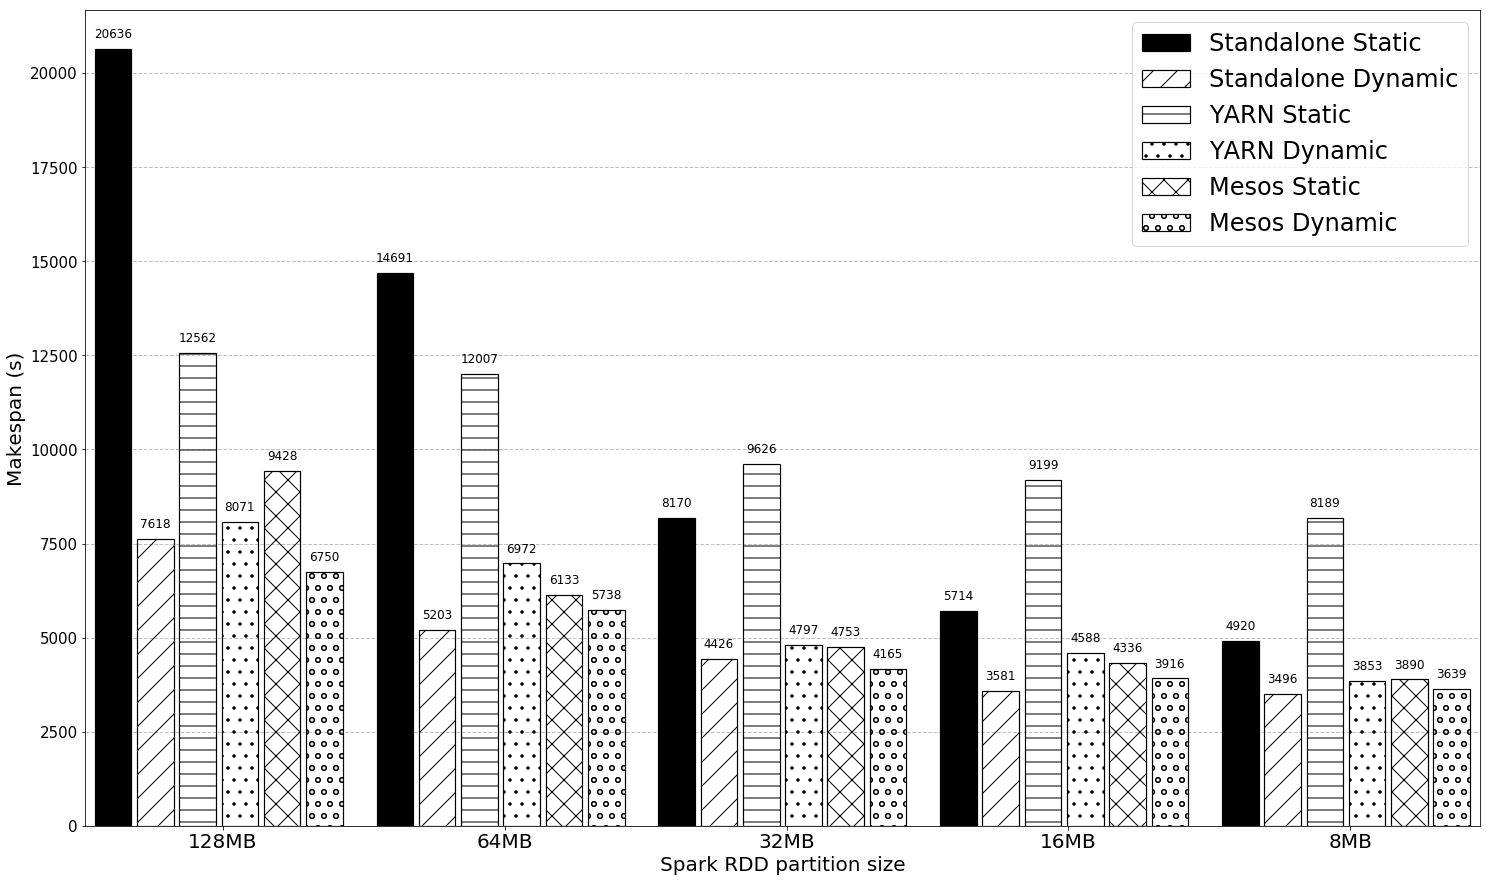

In [3]:
# Author: Habib Sabiu
# Date: March 31, 2017
# Purpose: Script to plot nice graphs for comparing jobs makespan
# Copyright: Any person can adopt this script for their specific need

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


# Static Vs Dynamic: 1cpu 2gb, without speculation data
raw_data = {'job_name': ['128MB', '64MB', '32MB', '16MB', '8MB'], #x-axis
            'Standalone Static': [20636, 14691, 8170, 5714, 4920], #y-axis
            'Standalone Dynamic': [7618, 5203, 4426, 3581, 3496], 
            'YARN Static': [12562, 12007, 9626, 9199, 8189],
            'YARN Dynamic': [8071, 6972, 4797, 4588, 3853], 
            'Mesos Static': [9428, 6133, 4753, 4336, 3890], 
            'Mesos Dynamic': [6750, 5738, 4165, 3916, 3639]}


df = pd.DataFrame(raw_data, columns=['job_name', 'Standalone Static', 'Standalone Dynamic', 'YARN Static', 'YARN Dynamic', 'Mesos Static', 'Mesos Dynamic'])

# Setting the positions and width for the bars
pos = list(range(len(df['Standalone Static'])))
width = 0.13

# Plotting the bars
fig, ax = plt.subplots(figsize=(25, 15))

bar1 = plt.bar(pos, df['Standalone Static'], width, color='black', edgecolor="k", lw=1.2)
bar2 = plt.bar([p + width + 0.02 for p in pos], df['Standalone Dynamic'], width, color='none', hatch="/", edgecolor="k", ls="solid", lw=1.2)
bar3 = plt.bar([p + (width * 2) + 0.04 for p in pos], df['YARN Static'], width, color='none', hatch="-", edgecolor="k", ls="solid",lw=1.2)
bar4 = plt.bar([p + (width * 3) + 0.06 for p in pos], df['YARN Dynamic'], width, color='none', hatch=".", edgecolor="k", ls="solid", lw=1.2)
bar5 = plt.bar([p + (width * 4) + 0.08 for p in pos], df['Mesos Static'], width, color='none', hatch="x", edgecolor="k", ls="solid",lw=1.2)
bar6 = plt.bar([p + (width * 5) + 0.10 for p in pos], df['Mesos Dynamic'], width, color='none', hatch="o", edgecolor="k", ls="solid", lw=1.2)

#ax.set_title('Static Vs Dynamic resource allocation on standalone cluster manager (No speculative execution of tasks)', fontsize=20)

ax.set_ylabel('Makespan (s)', fontsize=20)
plt.yticks(fontsize=15)

ax.set_xticklabels(df['job_name'], fontsize=20)
ax.set_xticks([p + 3 * width for p in pos])
ax.set_xlabel('Spark RDD partition size', fontsize=20)

plt.xlim(-0.1, 4.85)
#plt.ylim([0, 1200])

fontP = FontProperties()
fontP.set_size("xx-large")

#plt.legend(['Standalone Static', 'Standalone Dynamic', 'YARN Static', 'YARN Dynamic', 'Mesos Static', 'Mesos Dynamic'], loc='best', prop=fontP)
plt.legend(['Standalone Static', 'Standalone Dynamic', 'YARN Static', 'YARN Dynamic', 'Mesos Static', 'Mesos Dynamic'], loc='best', fontsize=24)

ax.set_axisbelow(True)
#ax.grid(color='#bfbfbf', linestyle='--', linewidth=1)
ax.yaxis.grid(which="major", color='#bfbfbf', linestyle='--', linewidth=1)


def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()
        label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position, '%d' % int(height), ha='center', va='bottom', fontsize=12)


autolabel(bar1, ax)
autolabel(bar2, ax)
autolabel(bar3, ax)
autolabel(bar4, ax)
autolabel(bar5, ax)
autolabel(bar6, ax)

plt.savefig('/Users/habib/Desktop/runtime_staticVsdynamic_1cpu_2gb_nospeculation.pdf', format='pdf', dpi=10000)

plt.show()